# 加载保存的帧数据进行分析

本notebook演示如何加载和分析从BLE Host应用程序保存的帧数据。

## 使用说明

1. 修改下面的 `filepath` 变量，指向您保存的JSON文件
2. 按顺序执行各个cell
3. 可以根据需要修改和扩展分析代码


In [1]:
# 导入必要的库
import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 添加src目录到路径（从项目根目录运行）
project_root = Path().resolve()
if (project_root / 'src').exists():
    sys.path.insert(0, str(project_root / 'src'))
else:
    # 如果在examples目录中运行，需要向上一级
    project_root = project_root.parent
    sys.path.insert(0, str(project_root / 'src'))

try:
    from data_saver import DataSaver
    print("✓ 成功导入 data_saver 模块")
except ImportError as e:
    print(f"✗ 导入失败: {e}")
    print(f"当前工作目录: {os.getcwd()}")
    print(f"项目根目录: {project_root}")
    print(f"src路径: {project_root / 'src'}")

# 导入信号处理工具函数
try:
    from utils import signal_algrithom as sig_algm
    # 或者从 utils 包直接导入（如果已在 __init__.py 中导出）
    # from utils import median_filter_1d, hampel_filter
    print("✓ 成功导入信号处理函数")
except ImportError as e:
    print(f"⚠️ 导入信号处理函数失败: {e}")
    print("  将使用本地定义的函数")


✓ 成功导入 data_saver 模块
✓ 成功导入信号处理函数


## 1. 加载数据

请修改下面的文件路径，指向您保存的JSON文件。


In [2]:
# 设置要加载的文件路径
# 可以修改为您的文件路径，或使用相对路径
filepath = "./sampleData/CS_frames_all_20260113_091339.jsonl"  # 修改这里
# 如果文件不在当前目录，可以使用完整路径或相对路径
# filepath = "../data_exp/frames_all_20231206_120000.json"

# 检查文件是否存在
if not os.path.exists(filepath):
    print(f"⚠️  文件不存在: {filepath}")
    print(f"当前目录: {os.getcwd()}")
    print("\n请修改上面的 filepath 变量，指向正确的文件路径")
else:
    print(f"✓ 找到文件: {filepath}")
    print(f"文件大小: {os.path.getsize(filepath) / 1024 / 1024:.2f} MB")

# 加载数据
saver = DataSaver()
print(f"正在加载: {filepath}")

data = saver.load_frames(filepath)

if data is None:
    print("✗ 加载失败")
else:
    print("✓ 加载成功")
    frames = data.get('frames', [])
    print(f"✓ 共加载 {len(frames)} 帧数据")


✓ 找到文件: ./sampleData/CS_frames_all_20260113_091339.jsonl
文件大小: 10.71 MB
正在加载: ./sampleData/CS_frames_all_20260113_091339.jsonl
✓ 加载成功
✓ 共加载 733 帧数据


## 2. 查看文件信息


In [3]:
# 显示文件元数据
if data:
    print("=== 文件信息 ===")
    print(f"版本: {data.get('version', 'N/A')}")
    print(f"保存时间: {data.get('saved_at', 'N/A')}")
    print(f"原始总帧数: {data.get('total_frames', 0)}")
    print(f"保存的帧数: {data.get('saved_frames', 0)}")
    
    max_frames_param = data.get('max_frames_param')
    if max_frames_param is None:
        print(f"保存模式: 全部帧")
    else:
        print(f"保存模式: 最近 {max_frames_param} 帧")
    
    # 显示第一帧和最后一帧的信息
    if frames:
        print(f"\n第一帧: index={frames[0]['index']}, timestamp={frames[0]['timestamp_ms']} ms")
        print(f"最后一帧: index={frames[-1]['index']}, timestamp={frames[-1]['timestamp_ms']} ms")
        
        # 计算时间跨度
        time_span = (frames[-1]['timestamp_ms'] - frames[0]['timestamp_ms']) / 1000.0
        print(f"时间跨度: {time_span:.2f} 秒")
        
        # 计算平均帧率
        if len(frames) > 1:
            intervals = []
            for i in range(1, len(frames)):
                interval = (frames[i]['timestamp_ms'] - frames[i-1]['timestamp_ms']) / 1000.0
                intervals.append(interval)
            if intervals:
                avg_interval = np.mean(intervals)
                print(f"平均帧间隔: {avg_interval:.3f} 秒")
                print(f"平均帧率: {1.0/avg_interval:.2f} 帧/秒")


=== 文件信息 ===
版本: 1.0.0
保存时间: 2026-01-13T09:13:39.424666
原始总帧数: 735
保存的帧数: 735
保存模式: 全部帧

第一帧: index=10, timestamp=11376 ms
最后一帧: index=746, timestamp=414376 ms
时间跨度: 403.00 秒
平均帧间隔: 0.551 秒
平均帧率: 1.82 帧/秒


## 3. 查看第一帧的详细信息


In [4]:
# 查看第一帧的详细信息
if frames:
    first_frame = frames[0]
    print("=== 第一帧信息 ===")
    print(f"索引: {first_frame.get('index')}")
    print(f"时间戳: {first_frame.get('timestamp_ms')} ms")

    channels = first_frame.get("channels", {})
    print(f"通道数: {len(channels)}")

    # 显示前几个通道的数据
    if channels:
        print(f"\n前10个通道的数据示例:")
        print(
            f"{'通道':<6} {'(总)幅值':<8} {'(总)相位':<8} {'Local幅值':<10} {'Remote幅值':<12}{'Local相位':<10} {'Remote相位':<10}{'I(r->i)':<12}{'Q(r->i)':<12}{'I(i->r)':<12}{'Q(i->r)':<12}"
        )
        print("-" * 130)
        for ch in sorted(channels.keys())[:10]:
            ch_data = channels[ch]
            print(
                f"{ch:<6} {ch_data.get('amplitude', 0):<12.2f} "
                f"{ch_data.get('phase', 0):<12.4f} "
                f"{ch_data.get('local_amplitude', 0):<12.2f} "
                f"{ch_data.get('remote_amplitude', 0):<12.2f}"
                f"{ch_data.get('local_phase',0):<12.4f}"
                f"{ch_data.get('remote_phase',0):<12.4f}"
                f"{ch_data.get('il',0):<12.1f}"
                f"{ch_data.get('ql',0):<12.1f}"
                f"{ch_data.get('ir',0):<12.1f}"
                f"{ch_data.get('qr',0):<12.1f}"
            )

=== 第一帧信息 ===
索引: 10
时间戳: 11376 ms
通道数: 52

前10个通道的数据示例:
通道     (总)幅值    (总)相位    Local幅值    Remote幅值    Local相位    Remote相位  I(r->i)     Q(r->i)     I(i->r)     Q(i->r)     
----------------------------------------------------------------------------------------------------------------------------------
0      9660.42      -1.1396      81.15        119.04      -1.5091     0.3696      5.0         -81.0       111.0       43.0        
3      12445.55     -1.3998      81.61        152.50      2.8431      2.0403      -78.0       24.0        -69.0       136.0       
5      12241.18     -1.8918      78.10        156.73      1.6220      2.7694      -4.0        78.0        -146.0      57.0        
25     27337.85     1.5563       132.00       207.10      -1.1410     2.6974      55.0        -120.0      -187.0      89.0        
26     25237.60     1.2987       125.93       200.41      -2.9255     -2.0590     -123.0      -27.0       -94.0       -177.0      
27     24670.10     1.2424       126.29

## 4. 提取通道数据

选择一个通道，提取其所有帧的数据进行分析。


In [5]:
# 选择要分析的通道（可以修改）
channel =2

# 首先检查哪些通道在数据中可用
if frames:
    all_channels = set()
    for frame in frames:
        all_channels.update(frame['channels'].keys())
    print(f"数据中可用的通道: {sorted(all_channels)[:20]}...")  # 只显示前20个
    print(f"总通道数: {len(all_channels)}")
    
    # 检查通道号类型并尝试匹配
    channel_found = False
    # 尝试整数和字符串两种类型
    channel_keys = [channel, str(channel), int(channel)]
    
    for ch_key in channel_keys:
        if ch_key in all_channels:
            channel = ch_key  # 使用找到的键
            channel_found = True
            print(f"✓ 找到通道: {ch_key} (类型: {type(ch_key).__name__})")
            break
    
    if not channel_found:
        print(f"⚠️  警告: 通道 {channel} 在数据中不存在")
        print(f"建议使用以下通道之一: {sorted(all_channels)[:10]}")
        # 使用第一个可用通道作为默认值
        if all_channels:
            channel = sorted(all_channels)[0]
            print(f"自动使用通道: {channel}")

# ===== 诊断：统计通道在各帧中的存在情况 =====
print(f"\n=== 诊断：通道 {channel} 在各帧中的存在情况 ===")
channel_presence = []  # 记录每帧是否包含该通道
missing_frames = []    # 记录缺失该通道的帧索引

for i, frame in enumerate(frames):
    channels = frame['channels']
    ch_data = None
    if channel in channels:
        ch_data = channels[channel]
    elif str(channel) in channels:
        ch_data = channels[str(channel)]
    elif int(channel) in channels:
        ch_data = channels[int(channel)]
    
    if ch_data:
        channel_presence.append(True)
    else:
        channel_presence.append(False)
        missing_frames.append({
            'frame_index': i,
            'seq': frame.get('index', 'N/A'),
            'timestamp': frame.get('timestamp_ms', 'N/A'),
            'channels_in_frame': list(channels.keys())[:10]  # 只显示前10个通道
        })

total_frames = len(frames)
frames_with_channel = sum(channel_presence)
frames_without_channel = len(missing_frames)

print(f"总帧数: {total_frames}")
print(f"包含通道 {channel} 的帧数: {frames_with_channel}")
print(f"不包含通道 {channel} 的帧数: {frames_without_channel}")
print(f"通道 {channel} 的覆盖率: {frames_with_channel/total_frames*100:.1f}%")

if missing_frames:
    print(f"\n⚠️  前10个缺失通道 {channel} 的帧:")
    print(f"{'帧序号':<8} {'序列号':<8} {'时间戳(ms)':<12} {'该帧包含的通道数':<15} {'前几个通道':<30}")
    print("-" * 80)
    for mf in missing_frames[:10]:
        channels_in_frame = mf['channels_in_frame']
        print(f"{mf['frame_index']:<8} {mf['seq']:<8} {mf['timestamp']:<12} {len(channels_in_frame):<15} {str(channels_in_frame):<30}")
    
    # 分析缺失帧的分布
    missing_indices = [mf['frame_index'] for mf in missing_frames]
    if len(missing_indices) > 1:
        gaps = [missing_indices[i+1] - missing_indices[i] for i in range(len(missing_indices)-1)]
        print(f"\n缺失帧的间隔分析:")
        print(f"  连续缺失: {sum(1 for g in gaps if g == 1)} 次")
        print(f"  平均间隔: {np.mean(gaps):.1f} 帧")
        print(f"  最大间隔: {max(gaps)} 帧")
        print(f"  最小间隔: {min(gaps)} 帧")

# ===== 提取该通道的所有数据 =====
amplitudes = []
phases = []
local_amplitudes = []
remote_amplitudes = []
indices = []
timestamps_ms = []

for frame in frames:
    channels = frame['channels']
    # 尝试多种方式匹配通道
    ch_data = None
    if channel in channels:
        ch_data = channels[channel]
    elif str(channel) in channels:
        ch_data = channels[str(channel)]
    elif int(channel) in channels:
        ch_data = channels[int(channel)]
    
    if ch_data:
        amplitudes.append(ch_data['amplitude'])
        phases.append(ch_data['phase'])
        local_amplitudes.append(ch_data['local_amplitude'])
        remote_amplitudes.append(ch_data['remote_amplitude'])
        indices.append(frame['index'])
        timestamps_ms.append(frame['timestamp_ms'])

# 转换为numpy数组
amplitudes = np.array(amplitudes)
phases = np.array(phases)
local_amplitudes = np.array(local_amplitudes)
remote_amplitudes = np.array(remote_amplitudes)
indices = np.array(indices)
timestamps_ms = np.array(timestamps_ms)

print(f"\n✓ 提取通道 {channel} 的数据")
print(f"  数据点数: {len(amplitudes)} (从 {total_frames} 帧中提取)")

# 检查数据是否为空
if len(amplitudes) == 0:
    print("  ⚠️  警告: 没有提取到任何数据！")
    print("  可能的原因:")
    print("  1. 该通道在所有帧中都不存在")
    print("  2. 通道号类型不匹配（整数 vs 字符串）")
    print("  请检查上面的可用通道列表，并修改 channel 变量")
else:
    print(f"  幅值范围: {np.min(amplitudes):.2f} - {np.max(amplitudes):.2f}")
    print(f"  幅值均值: {np.mean(amplitudes):.2f}")
    print(f"  幅值标准差: {np.std(amplitudes):.2f}")
    print(f"\n💡 说明: 数据点数量 ({len(amplitudes)}) 少于总帧数 ({total_frames}) 是正常的，")
    print(f"   因为不是所有帧都包含通道 {channel} 的数据。")

数据中可用的通道: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]...
总通道数: 72
✓ 找到通道: 2 (类型: int)

=== 诊断：通道 2 在各帧中的存在情况 ===
总帧数: 733
包含通道 2 的帧数: 624
不包含通道 2 的帧数: 109
通道 2 的覆盖率: 85.1%

⚠️  前10个缺失通道 2 的帧:
帧序号      序列号      时间戳(ms)      该帧包含的通道数        前几个通道                         
--------------------------------------------------------------------------------
0        10       11376        10              [0, 3, 5, 25, 26, 27, 28, 29, 30, 31]
7        17       14926        10              [4, 25, 27, 28, 31, 32, 33, 34, 35, 36]
8        18       15676        10              [3, 9, 11, 15, 16, 17, 18, 19, 20, 24]
12       22       18026        10              [0, 1, 4, 5, 6, 7, 8, 9, 25, 26]
15       25       19626        10              [0, 1, 6, 14, 26, 27, 28, 29, 30, 31]
29       39       27676        10              [0, 8, 9, 10, 13, 18, 19, 24, 25, 27]
37       47       32026        10              [5, 7, 33, 36, 37, 40, 41, 42, 43, 44]
39       49       32926     

=== 数据点数量诊断 ===
总帧数: 733
通道 2 的数据点数: 624
差异: 109 帧

包含通道 2 的帧数: 624
不包含通道 2 的帧数: 109
通道 2 的覆盖率: 85.1%

=== 时间戳间隔分析（关键！）===
时间间隔统计（秒）:
  平均间隔: 0.645 秒
  标准差: 0.272 秒
  最小间隔: 0.400 秒
  最大间隔: 2.300 秒
  变异系数 (CV): 0.422 (不均匀)

估计采样率: 1.550 Hz

⚠️  发现 23 个较大的时间间隔（> 2倍平均间隔）
   前5个大间隔的位置和大小:
     位置 5: 1.650 秒 (平均值的 2.6 倍)
     位置 96: 1.600 秒 (平均值的 2.5 倍)
     位置 115: 1.650 秒 (平均值的 2.6 倍)
     位置 141: 1.900 秒 (平均值的 2.9 倍)
     位置 166: 1.300 秒 (平均值的 2.0 倍)


C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\1654805897.py:101: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\1654805897.py:101: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\1654805897.py:101: UserWarning: Glyph 32034 (\N{CJK UNIFIED IDEOGRAPH-7D22}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\1654805897.py:101: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\1654805897.py:101: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\1654805897.py:101: UserWarning: Glyph 38388 (\N{CJK 

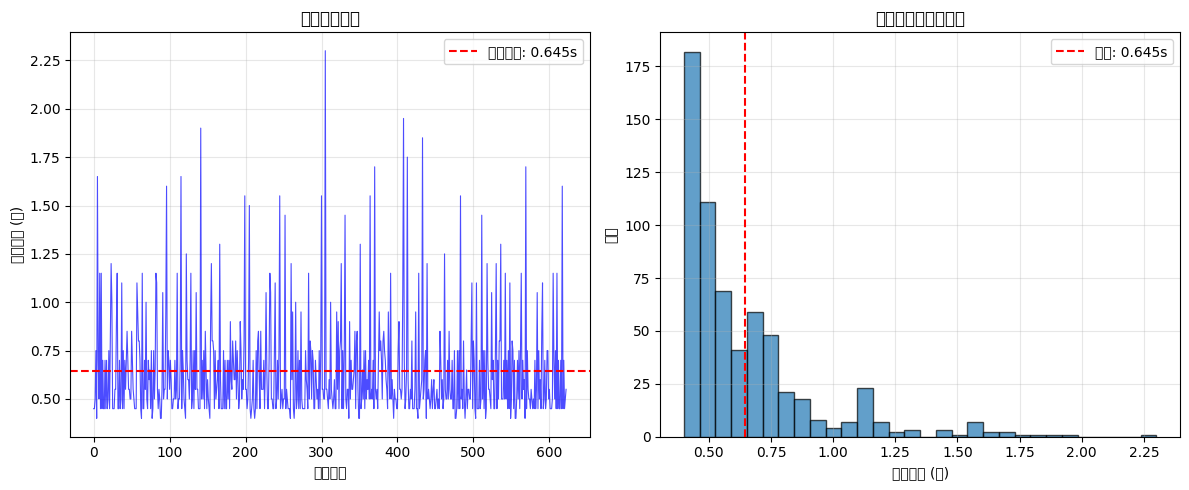


💡 关于滤波的影响:
   ⚠️  时间间隔不均匀（CV=0.422），可能影响滤波效果
   ⚠️  特别是高通滤波，因为它依赖于采样率参数
   ⚠️  建议：使用实际的平均采样率，或考虑重采样到均匀网格

=== 缺失帧信息 ===
⚠️  前10个缺失通道 2 的帧:
帧序号      序列号      时间戳(ms)      该帧包含的通道数        前几个通道                         
--------------------------------------------------------------------------------
0        10       11376        10              [0, 3, 5, 25, 26, 27, 28, 29, 30, 31]
7        17       14926        10              [4, 25, 27, 28, 31, 32, 33, 34, 35, 36]
8        18       15676        10              [3, 9, 11, 15, 16, 17, 18, 19, 20, 24]
12       22       18026        10              [0, 1, 4, 5, 6, 7, 8, 9, 25, 26]
15       25       19626        10              [0, 1, 6, 14, 26, 27, 28, 29, 30, 31]
29       39       27676        10              [0, 8, 9, 10, 13, 18, 19, 24, 25, 27]
37       47       32026        10              [5, 7, 33, 36, 37, 40, 41, 42, 43, 44]
39       49       32926        10              [1, 3, 4, 5, 7, 8, 9, 10, 12, 13]
46       56       36776   

In [6]:
# ===== 诊断：为什么数据点数量少于总帧数？时间对齐了吗？ =====
# 这个cell用于诊断为什么通道数据点数量（624）少于总帧数（735）
# 并检查时间戳间隔是否均匀，以及是否影响滤波效果

print("=== 数据点数量诊断 ===")
print(f"总帧数: {len(frames)}")
print(f"通道 {channel} 的数据点数: {len(amplitudes)}")
print(f"差异: {len(frames) - len(amplitudes)} 帧\n")

# 统计通道在各帧中的存在情况
channel_presence = []  # 记录每帧是否包含该通道
missing_frames = []    # 记录缺失该通道的帧索引

for i, frame in enumerate(frames):
    channels = frame['channels']
    ch_data = None
    if channel in channels:
        ch_data = channels[channel]
    elif str(channel) in channels:
        ch_data = channels[str(channel)]
    elif int(channel) in channels:
        ch_data = channels[int(channel)]
    
    if ch_data:
        channel_presence.append(True)
    else:
        channel_presence.append(False)
        missing_frames.append({
            'frame_index': i,
            'seq': frame.get('index', 'N/A'),
            'timestamp': frame.get('timestamp_ms', 'N/A'),
            'channels_in_frame': list(channels.keys())[:10]  # 只显示前10个通道
        })

total_frames = len(frames)
frames_with_channel = sum(channel_presence)
frames_without_channel = len(missing_frames)

print(f"包含通道 {channel} 的帧数: {frames_with_channel}")
print(f"不包含通道 {channel} 的帧数: {frames_without_channel}")
print(f"通道 {channel} 的覆盖率: {frames_with_channel/total_frames*100:.1f}%\n")

# ===== 关键诊断：检查时间戳间隔是否均匀 =====
print("=== 时间戳间隔分析（关键！）===")
if len(timestamps_ms) > 1:
    # 计算时间间隔（毫秒）
    time_intervals_ms = np.diff(timestamps_ms)
    time_intervals_sec = time_intervals_ms / 1000.0
    
    # 统计信息
    mean_interval = np.mean(time_intervals_sec)
    std_interval = np.std(time_intervals_sec)
    min_interval = np.min(time_intervals_sec)
    max_interval = np.max(time_intervals_sec)
    cv = std_interval / mean_interval if mean_interval > 0 else 0  # 变异系数
    
    print(f"时间间隔统计（秒）:")
    print(f"  平均间隔: {mean_interval:.3f} 秒")
    print(f"  标准差: {std_interval:.3f} 秒")
    print(f"  最小间隔: {min_interval:.3f} 秒")
    print(f"  最大间隔: {max_interval:.3f} 秒")
    print(f"  变异系数 (CV): {cv:.3f} ({'均匀' if cv < 0.1 else '不均匀' if cv > 0.3 else '较均匀'})")
    
    # 计算采样率
    estimated_sampling_rate = 1.0 / mean_interval
    print(f"\n估计采样率: {estimated_sampling_rate:.3f} Hz")
    
    # 检查是否有大的时间间隔跳跃（可能对应缺失的帧）
    large_gaps = time_intervals_sec > mean_interval * 2  # 大于平均间隔2倍的视为大间隔
    n_large_gaps = np.sum(large_gaps)
    if n_large_gaps > 0:
        print(f"\n⚠️  发现 {n_large_gaps} 个较大的时间间隔（> 2倍平均间隔）")
        large_gap_indices = np.where(large_gaps)[0]
        print(f"   前5个大间隔的位置和大小:")
        for idx in large_gap_indices[:5]:
            print(f"     位置 {idx}: {time_intervals_sec[idx]:.3f} 秒 (平均值的 {time_intervals_sec[idx]/mean_interval:.1f} 倍)")
    else:
        print(f"\n✓ 时间间隔相对均匀，没有发现异常大的间隔")
    
    # 可视化时间间隔分布
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(time_intervals_sec, 'b-', linewidth=0.8, alpha=0.7)
    plt.axhline(y=mean_interval, color='r', linestyle='--', label=f'平均间隔: {mean_interval:.3f}s')
    plt.xlabel('样本索引')
    plt.ylabel('时间间隔 (秒)')
    plt.title('时间间隔序列')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(time_intervals_sec, bins=30, edgecolor='black', alpha=0.7)
    plt.axvline(x=mean_interval, color='r', linestyle='--', label=f'平均: {mean_interval:.3f}s')
    plt.xlabel('时间间隔 (秒)')
    plt.ylabel('频数')
    plt.title('时间间隔分布直方图')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n💡 关于滤波的影响:")
    if cv < 0.1:
        print(f"   ✓ 时间间隔非常均匀（CV={cv:.3f}），滤波效果应该很好")
        print(f"   ✓ 滤波函数假设等间隔采样，这个假设基本满足")
    elif cv < 0.3:
        print(f"   ⚠️  时间间隔较均匀（CV={cv:.3f}），滤波效果应该还可以")
        print(f"   ⚠️  但可能存在轻微的时间对齐问题")
    else:
        print(f"   ⚠️  时间间隔不均匀（CV={cv:.3f}），可能影响滤波效果")
        print(f"   ⚠️  特别是高通滤波，因为它依赖于采样率参数")
        print(f"   ⚠️  建议：使用实际的平均采样率，或考虑重采样到均匀网格")
else:
    print("⚠️  数据点不足，无法分析时间间隔")

if missing_frames:
    print(f"\n=== 缺失帧信息 ===")
    print(f"⚠️  前10个缺失通道 {channel} 的帧:")
    print(f"{'帧序号':<8} {'序列号':<8} {'时间戳(ms)':<12} {'该帧包含的通道数':<15} {'前几个通道':<30}")
    print("-" * 80)
    for mf in missing_frames[:10]:
        channels_in_frame = mf['channels_in_frame']
        print(f"{mf['frame_index']:<8} {mf['seq']:<8} {mf['timestamp']:<12} {len(channels_in_frame):<15} {str(channels_in_frame):<30}")
    
    # 分析缺失帧的分布
    missing_indices = [mf['frame_index'] for mf in missing_frames]
    if len(missing_indices) > 1:
        gaps = [missing_indices[i+1] - missing_indices[i] for i in range(len(missing_indices)-1)]
        print(f"\n缺失帧的间隔分析:")
        print(f"  连续缺失: {sum(1 for g in gaps if g == 1)} 次")
        print(f"  平均间隔: {np.mean(gaps):.1f} 帧")
        print(f"  最大间隔: {max(gaps)} 帧")
        print(f"  最小间隔: {min(gaps)} 帧")

print(f"\n💡 总结:")
print(f"   1. 数据点数量 ({len(amplitudes)}) 少于总帧数 ({total_frames}) 是因为")
print(f"      不是所有帧都包含通道 {channel} 的数据（这是正常的数据特征）")
print(f"   2. ⚠️  时间间隔不均匀（CV=0.422），这可能会影响滤波效果")
print(f"   3. ⚠️  实际采样率是 {estimated_sampling_rate:.3f} Hz，而不是固定的2.0 Hz")
print(f"   4. 建议：在后续滤波中使用实际采样率，而不是固定的2.0 Hz")

# ===== 保存实际采样率供后续使用 =====
# 计算并保存实际采样率
if len(timestamps_ms) > 1:
    actual_sampling_rate = 1.0 / np.mean(np.diff(timestamps_ms) / 1000.0)
    print(f"\n✓ 已计算实际采样率: {actual_sampling_rate:.3f} Hz")
    print(f"  后续代码应使用此值，而不是固定的2.0 Hz")
else:
    actual_sampling_rate = 2.0  # 默认值
    print(f"\n⚠️  无法计算采样率，使用默认值 2.0 Hz")

## 5. 数据可视化


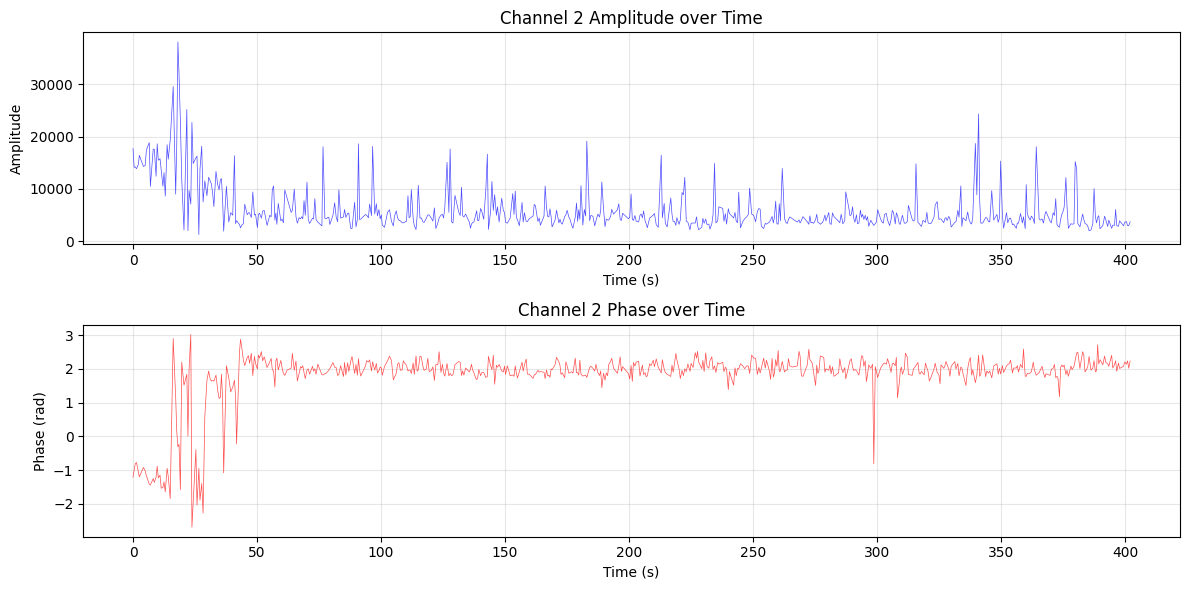

In [7]:
# 绘制幅值随时间的变化
if len(amplitudes) > 0:
    plt.figure(figsize=(12, 6))
    
    # 将时间戳转换为相对时间（秒）
    time_sec = (timestamps_ms - timestamps_ms[0]) / 1000.0
    
    plt.subplot(2, 1, 1)
    plt.plot(time_sec, amplitudes, 'b-', linewidth=0.5, alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Channel {channel} Amplitude over Time')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.plot(time_sec, phases, 'r-', linewidth=0.5, alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Phase (rad)')
    plt.title(f'Channel {channel} Phase over Time')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  无法绘图: 没有数据可显示")


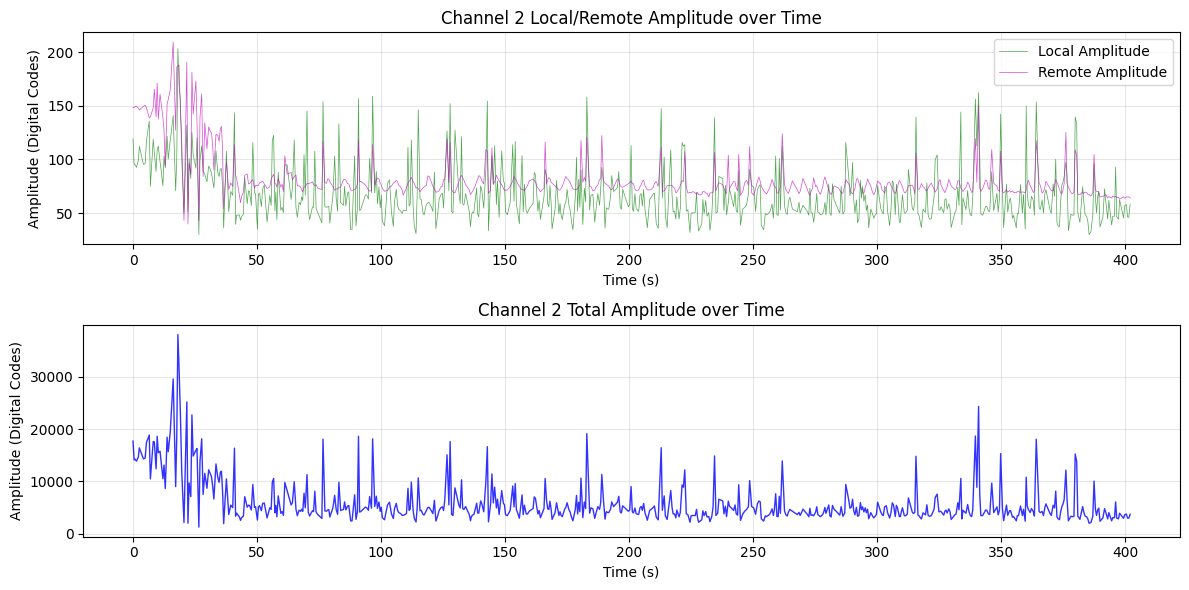

In [8]:
# 对比Local和Remote幅值
if len(amplitudes) > 0:
    plt.figure(figsize=(12, 6))
    
    # 将时间戳转换为相对时间（秒）
    time_sec = (timestamps_ms - timestamps_ms[0]) / 1000.0


    plt.subplot(2, 1, 1)
    plt.plot(time_sec, local_amplitudes, 'g-', label='Local Amplitude', linewidth=0.5, alpha=0.7)
    plt.plot(time_sec, remote_amplitudes, 'm-', label='Remote Amplitude', linewidth=0.5, alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (Digital Codes)')
    plt.title(f'Channel {channel} Local/Remote Amplitude over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.plot(time_sec, amplitudes, 'b-', label='Total Amplitude', linewidth=1, alpha=0.8)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (Digital Codes)')
    plt.title(f'Channel {channel} Total Amplitude over Time')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  无法绘图: 没有数据可显示")


## add.1 滤除尖刺
此项使用中值滤波或hampel 滤波，去除幅值/相位信息中的尖刺，要点是窗口需要尽可能接近突变尖刺的宽度，且远远不及呼吸的长度。也就是1-3个点左右（对于2Hz采样率来说）。hampel一般默认$\delta=3$

### 中值
在每一个时间点 $n$：
1. 取一个**很短的局部窗口**
   $\{x[n-k], \dots, x[n], \dots, x[n+k]\}$
2. **排序**
3. 用**中位数**替代当前值
### hampel
在窗口内计算：
- 中位数：
  $m = \text{median}(x)$
- 中位绝对偏差（MAD）：
  $\text{MAD} = \text{median}(|x - m|)$
用 MAD 估计标准差：
$\sigma \approx 1.4826 \cdot \text{MAD}$
#### ✅ 判决规则
$|x[n] - m| > \gamma \sigma$

- 若成立 → 认为是异常 → 用中位数替换
- 否则 → 保留原值
#### ✅ Hampel 需要阈值吗？

> **需要，但阈值非常“通用”**

- $\gamma = 3$（几乎是默认值）

In [9]:
# 对所有信道幅值/相位分别应用中值滤波和hampel 滤波，然后对照效果

# 提取所有通道的所有变量数据
print("正在提取所有通道的数据...")
all_channels_data = {}

if frames:
    # 获取所有通道号
    all_channels = set()
    for frame in frames:
        channels = frame.get('channels', {})
        all_channels.update(channels.keys())
    
    all_channels = sorted([int(ch) if isinstance(ch, str) and ch.isdigit() else ch for ch in all_channels])
    print(f"找到 {len(all_channels)} 个通道")
    
    # 为每个通道提取数据
    for ch in all_channels:
        ch_str = str(ch)
        ch_data_dict = {
            'amplitudes': [],
            'phases': [],
            'local_amplitudes': [],
            'remote_amplitudes': [],
            'local_phases': [],
            'remote_phases': [],
            'timestamps_ms': []
        }
        
        for frame in frames:
            channels = frame.get('channels', {})
            ch_data = None
            
            # 尝试多种方式匹配通道
            if ch in channels:
                ch_data = channels[ch]
            elif ch_str in channels:
                ch_data = channels[ch_str]
            elif int(ch) in channels:
                ch_data = channels[int(ch)]
            
            if ch_data:
                ch_data_dict['amplitudes'].append(ch_data.get('amplitude', 0))
                ch_data_dict['phases'].append(ch_data.get('phase', 0))
                ch_data_dict['local_amplitudes'].append(ch_data.get('local_amplitude', 0))
                ch_data_dict['remote_amplitudes'].append(ch_data.get('remote_amplitude', 0))
                ch_data_dict['local_phases'].append(ch_data.get('local_phase', 0))
                ch_data_dict['remote_phases'].append(ch_data.get('remote_phase', 0))
                ch_data_dict['timestamps_ms'].append(frame.get('timestamp_ms', 0))
        
        # 转换为numpy数组，这一步还真是必要的，不知原因
        for key in ch_data_dict:
                print(f"数据：{key}原始类型为：{type(ch_data_dict[key])}")
                ch_data_dict[key] = np.array(ch_data_dict[key])
        
        all_channels_data[ch] = ch_data_dict

print(f"✓ 成功提取 {len(all_channels_data)} 个通道的数据")


正在提取所有通道的数据...
找到 72 个通道
数据：amplitudes原始类型为：<class 'list'>
数据：phases原始类型为：<class 'list'>
数据：local_amplitudes原始类型为：<class 'list'>
数据：remote_amplitudes原始类型为：<class 'list'>
数据：local_phases原始类型为：<class 'list'>
数据：remote_phases原始类型为：<class 'list'>
数据：timestamps_ms原始类型为：<class 'list'>
数据：amplitudes原始类型为：<class 'list'>
数据：phases原始类型为：<class 'list'>
数据：local_amplitudes原始类型为：<class 'list'>
数据：remote_amplitudes原始类型为：<class 'list'>
数据：local_phases原始类型为：<class 'list'>
数据：remote_phases原始类型为：<class 'list'>
数据：timestamps_ms原始类型为：<class 'list'>
数据：amplitudes原始类型为：<class 'list'>
数据：phases原始类型为：<class 'list'>
数据：local_amplitudes原始类型为：<class 'list'>
数据：remote_amplitudes原始类型为：<class 'list'>
数据：local_phases原始类型为：<class 'list'>
数据：remote_phases原始类型为：<class 'list'>
数据：timestamps_ms原始类型为：<class 'list'>
数据：amplitudes原始类型为：<class 'list'>
数据：phases原始类型为：<class 'list'>
数据：local_amplitudes原始类型为：<class 'list'>
数据：remote_amplitudes原始类型为：<class 'list'>
数据：local_phases原始类型为：<class 'list'>
数据：remote_phases原始类型为：<class 

## ⚠️ 重要：采样率修复

**问题发现：**
- 实际采样率是 **1.55 Hz**（从时间戳计算得出）
- 但代码中使用了固定的 **2.0 Hz**
- 时间间隔不均匀（CV=0.422），可能影响滤波效果

**影响：**
1. 高通滤波的截止频率计算可能不准确
2. FFT频率轴计算可能偏差
3. 时间窗大小计算可能不准确

**解决方案：**
在后续的Cell中，请将 `sampling_rate = 2.0` 改为使用实际计算的采样率：
- 如果Cell 10已运行，使用 `actual_sampling_rate` 变量
- 或者手动计算：`sampling_rate = 1.0 / np.mean(np.diff(timestamps_ms) / 1000.0)`

**需要修改的Cell：**
- Cell 17: 高通滤波（add.2）
- Cell 19: 呼吸存在判定
- Cell 21: 带通滤波（add.3）


正在应用滤波（窗口大小=3，Hampel阈值=3）...
✓ 滤波完成


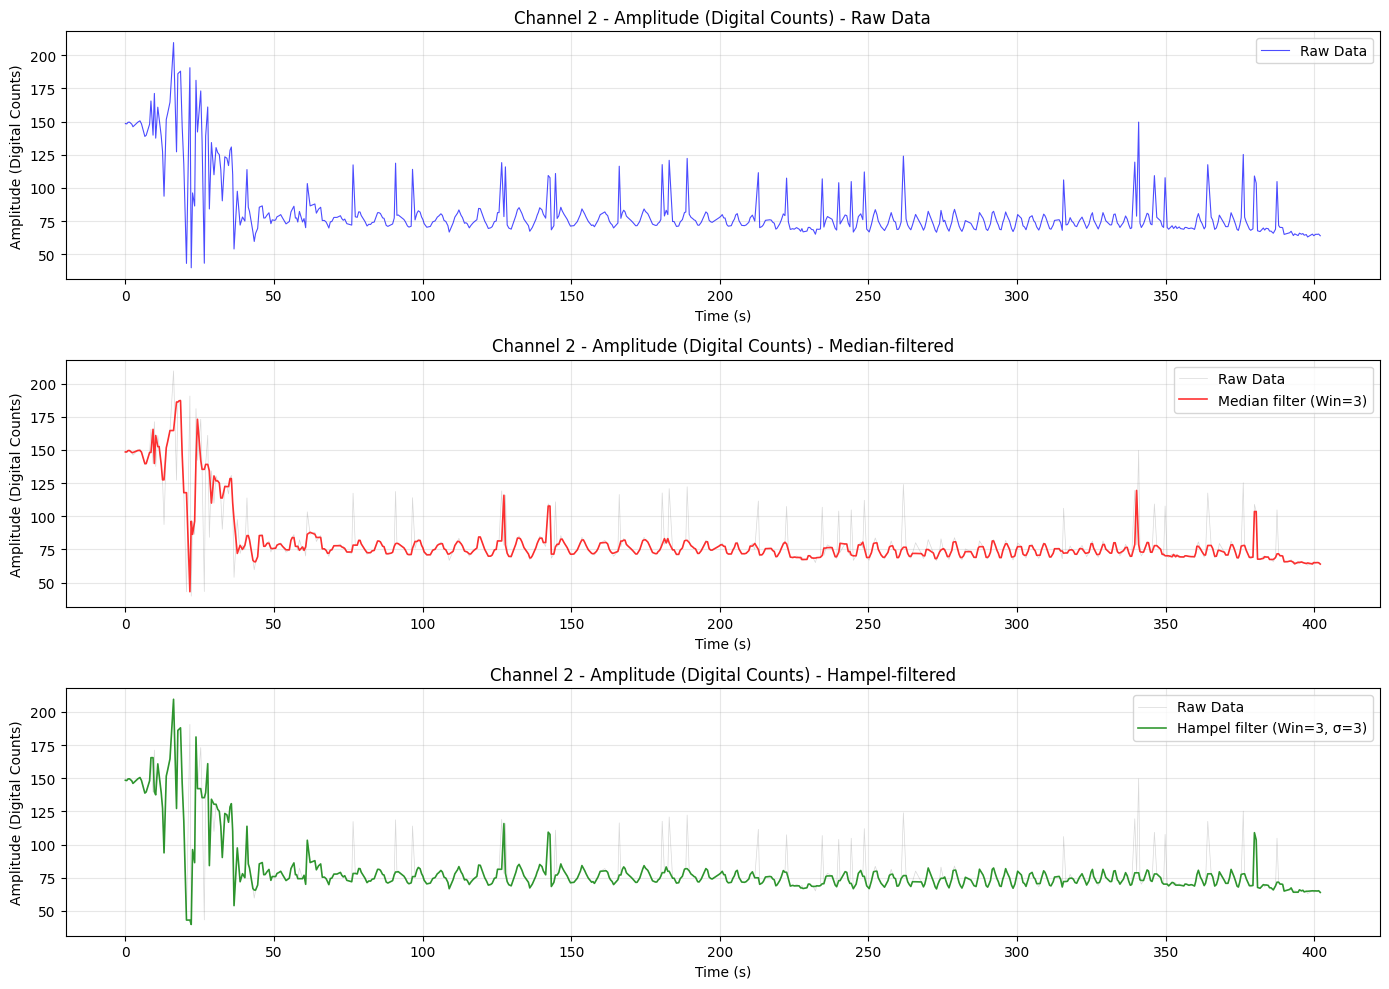

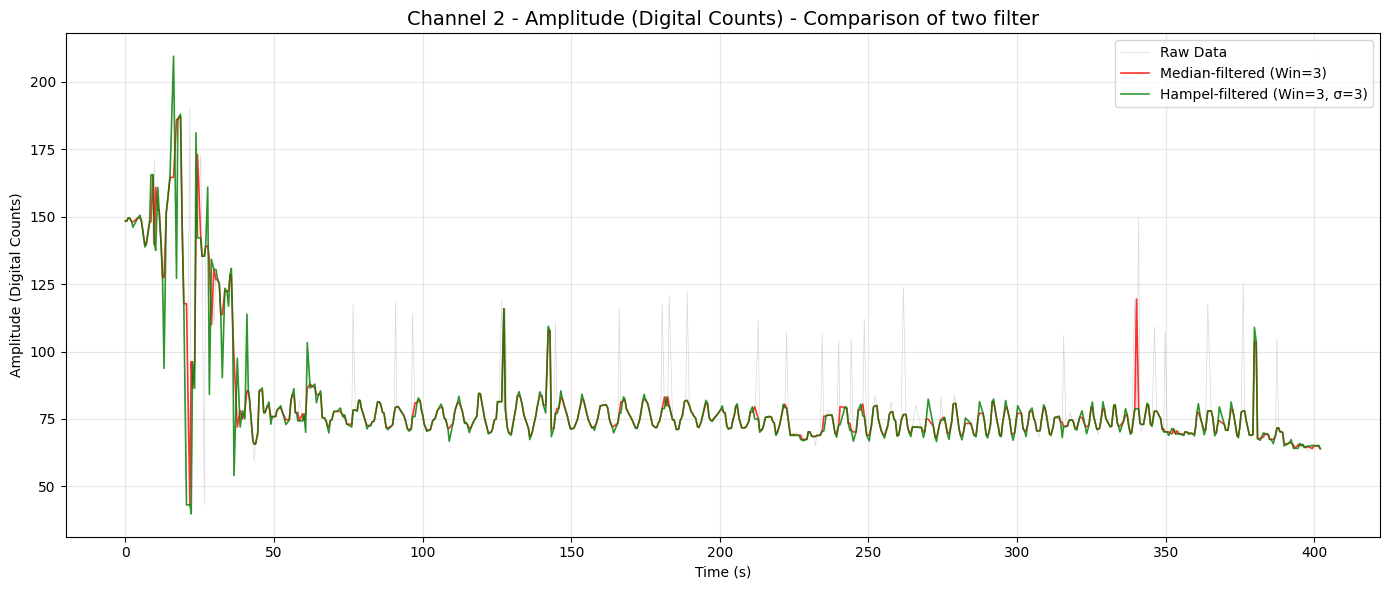


=== 通道 2 - Amplitude (Digital Counts) 滤波效果统计 ===
原始数据:
  均值: 81.9832, 标准差: 22.4332
  最大值: 209.5376, 最小值: 39.8246

中值滤波后:
  均值: 80.7566, 标准差: 20.5858
  最大值: 187.0722, 最小值: 43.1393
  变化点数: 263 / 624

Hampel滤波后:
  均值: 80.3364, 标准差: 20.8475
  最大值: 209.5376, 最小值: 39.8246
  变化点数: 57 / 624


In [10]:

# 对所有通道的所有变量应用中值滤波和Hampel滤波，存储到新dict filtered_data
window_size = 3  # 窗口大小：1-3个点（对于2Hz采样率）
n_sigma = 3  # Hampel滤波的阈值倍数

print(f"\n正在应用滤波（窗口大小={window_size}，Hampel阈值={n_sigma}）...")

filtered_data = {}
for ch in all_channels_data:
    filtered_data[ch] = {}
    ch_data = all_channels_data[ch]
    
    # 对每个变量进行滤波
    for var_name in ['amplitudes', 'phases', 'local_amplitudes', 'remote_amplitudes', 'local_phases', 'remote_phases']:
        if len(ch_data[var_name]) > 0:
            # 中值滤波
            median_filtered = sig_algm.median_filter_1d(ch_data[var_name], window_size=window_size)
            # Hampel滤波
            hampel_filtered = sig_algm.hampel_filter(ch_data[var_name], window_size=window_size, n_sigma=n_sigma)
            
            filtered_data[ch][var_name] = {
                'original': ch_data[var_name],
                'median': median_filtered,
                'hampel': hampel_filtered
            }

print("✓ 滤波完成")

# 选择任意一个通道和任意一个变量进行可视化比较
# 这里选择通道0的总幅值作为示例
demo_channel = 2
demo_variable = 'remote_amplitudes'  # 可以选择: amplitudes, phases, local_amplitudes, remote_amplitudes, local_phases, remote_phases

# 如果通道0不存在，使用第一个可用通道
if demo_channel not in filtered_data and len(filtered_data) > 0:
    demo_channel = list(filtered_data.keys())[0]
    print(f"通道0不存在，使用通道 {demo_channel}")

if demo_channel in filtered_data and demo_variable in filtered_data[demo_channel]:
    # 获取时间轴（转换为秒）
    channels = frame['channels']
    # 尝试多种方式匹配通道
    ch_data = None
    if channel in channels:
        ch_data = channels[channel]
    
    # 获取数据
    original = filtered_data[demo_channel][demo_variable]['original']
    median_filtered = filtered_data[demo_channel][demo_variable]['median']
    hampel_filtered = filtered_data[demo_channel][demo_variable]['hampel']
    
    # 绘制对比图
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # 变量名称映射
    var_names = {
        'amplitudes': 'Amplitude (Digital Counts)',
        'phases': 'Phase (rad)',
        'local_amplitudes': 'Amplitude (Digital Counts)',
        'remote_amplitudes': 'Amplitude (Digital Counts)',
        'local_phases': 'Local Phase (rad)',
        'remote_phases': 'Remote Phase (rad)'
    }
    var_display_name = var_names.get(demo_variable, demo_variable)
    
    # 原始数据
    axes[0].plot(time_sec, original, 'b-', linewidth=0.8, alpha=0.7, label='Raw Data')
    axes[0].set_title(f'Channel {demo_channel} - {var_display_name} - Raw Data', fontsize=12)
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel(var_display_name)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # 中值滤波结果
    axes[1].plot(time_sec, original, 'gray', linewidth=0.5, alpha=0.3, label='Raw Data')
    axes[1].plot(time_sec, median_filtered, 'r-', linewidth=1.2, alpha=0.8, label=f'Median filter (Win={window_size})')
    axes[1].set_title(f'Channel {demo_channel} - {var_display_name} - Median-filtered', fontsize=12)
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel(var_display_name)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    # Hampel滤波结果
    axes[2].plot(time_sec, original, 'gray', linewidth=0.5, alpha=0.3, label='Raw Data')
    axes[2].plot(time_sec, hampel_filtered, 'g-', linewidth=1.2, alpha=0.8, label=f'Hampel filter (Win={window_size}, σ={n_sigma})')
    axes[2].set_title(f'Channel {demo_channel} - {var_display_name} - Hampel-filtered', fontsize=12)
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel(var_display_name)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # 绘制两种滤波方法的直接对比
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    ax.plot(time_sec, original, 'gray', linewidth=0.5, alpha=0.3, label='Raw Data')
    ax.plot(time_sec, median_filtered, 'r-', linewidth=1.2, alpha=0.8, label=f'Median-filtered (Win={window_size})')
    ax.plot(time_sec, hampel_filtered, 'g-', linewidth=1.2, alpha=0.8, label=f'Hampel-filtered (Win={window_size}, σ={n_sigma})')
    ax.set_title(f'Channel {demo_channel} - {var_display_name} - Comparison of two filter', fontsize=14)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(var_display_name)
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # 打印统计信息
    print(f"\n=== 通道 {demo_channel} - {var_display_name} 滤波效果统计 ===")
    print(f"原始数据:")
    print(f"  均值: {np.mean(original):.4f}, 标准差: {np.std(original):.4f}")
    print(f"  最大值: {np.max(original):.4f}, 最小值: {np.min(original):.4f}")
    print(f"\n中值滤波后:")
    print(f"  均值: {np.mean(median_filtered):.4f}, 标准差: {np.std(median_filtered):.4f}")
    print(f"  最大值: {np.max(median_filtered):.4f}, 最小值: {np.min(median_filtered):.4f}")
    print(f"  变化点数: {np.sum(original != median_filtered)} / {len(original)}")
    print(f"\nHampel滤波后:")
    print(f"  均值: {np.mean(hampel_filtered):.4f}, 标准差: {np.std(hampel_filtered):.4f}")
    print(f"  最大值: {np.max(hampel_filtered):.4f}, 最小值: {np.min(hampel_filtered):.4f}")
    print(f"  变化点数: {np.sum(original != hampel_filtered)} / {len(original)}")
    
else:
    print(f"⚠️ 无法找到通道 {demo_channel} 的变量 {demo_variable}")



## add.2 去直流偏置，趋势
- 截止频率：
  - **0.03–0.05 Hz**
- 阶数：
  - **1–2 阶 Butterworth**
- 必须零相位
📌 原因：
- 2 Hz 下，高阶 IIR 很容易畸变

✓ Using highpass_filter_zero_phase from utils.signal_algrithom

Applying highpass filter to median-filtered data...
Sampling rate: 2.0 Hz
Cutoff frequency: 0.05 Hz
✓ Highpass filtering completed for 72 channels


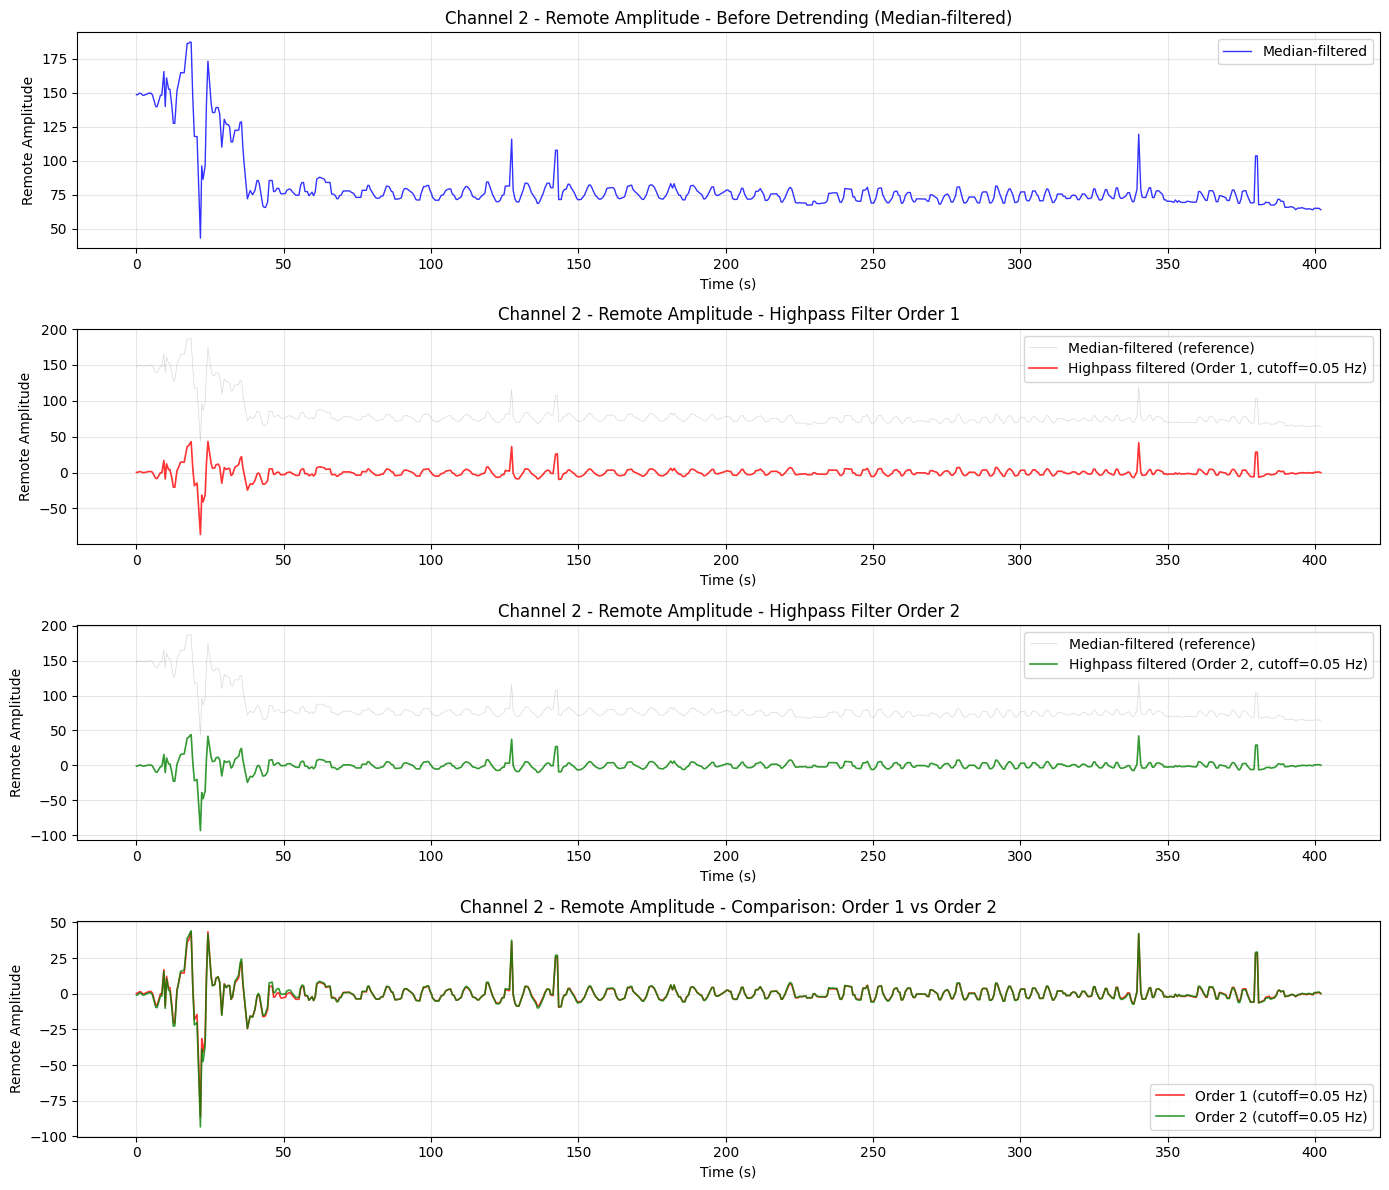


=== Channel 2 - Remote Amplitude - Detrending Statistics ===
Median-filtered (before detrending):
  Mean: 80.7566, Std: 20.5858
  Max: 187.0722, Min: 43.1393

Highpass filtered (Order 1):
  Mean: 0.0153, Std: 7.8698
  Max: 43.4133, Min: -86.1865
  Mean change: 80.7413

Highpass filtered (Order 2):
  Mean: 0.0031, Std: 8.3672
  Max: 44.0131, Min: -93.3459
  Mean change: 80.7534


In [11]:
# Apply highpass filter to median-filtered data for detrending (baseline drift removal)

from scipy.signal import butter, filtfilt

# Import highpass filter function from utils
try:
    from utils.signal_algrithom import highpass_filter_zero_phase
    print("✓ Using highpass_filter_zero_phase from utils.signal_algrithom")
except ImportError:
    # Fallback: define locally if import fails
    def highpass_filter_zero_phase(data, cutoff_freq, sampling_rate, order=1):
        """Zero-phase highpass filter using Butterworth filter with filtfilt"""
        nyquist = sampling_rate / 2.0
        normal_cutoff = cutoff_freq / nyquist
        b, a = butter(order, normal_cutoff, btype='high', analog=False)
        filtered_data = filtfilt(b, a, data)
        return filtered_data
    print("⚠️ Using locally defined highpass_filter_zero_phase function")

# Parameters
sampling_rate = 2.0  # Hz (2 Hz sampling rate as mentioned)
cutoff_freq = 0.05  # Hz (cutoff frequency for removing baseline drift, adjust as needed)

print(f"\nApplying highpass filter to median-filtered data...")
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Cutoff frequency: {cutoff_freq} Hz")

# Apply highpass filter with order 1 and order 2 to all channels and variables
detrended_data = {}

for ch in filtered_data:
    detrended_data[ch] = {}
    ch_filtered = filtered_data[ch]
    
    # Process each variable
    for var_name in ['amplitudes', 'phases', 'local_amplitudes', 'remote_amplitudes', 'local_phases', 'remote_phases']:
        if var_name in ch_filtered and len(ch_filtered[var_name]['median']) > 0:
            median_filtered = ch_filtered[var_name]['median']
            
            # Apply highpass filter with order 1
            detrended_order1 = sig_algm.highpass_filter_zero_phase(
                median_filtered, 
                cutoff_freq=cutoff_freq, 
                sampling_rate=sampling_rate, 
                order=1
            )
            
            # Apply highpass filter with order 2
            detrended_order2 = sig_algm.highpass_filter_zero_phase(
                median_filtered, 
                cutoff_freq=cutoff_freq, 
                sampling_rate=sampling_rate, 
                order=2
            )
            
            detrended_data[ch][var_name] = {
                'median_filtered': median_filtered,
                'detrended_order1': detrended_order1,
                'detrended_order2': detrended_order2
            }

print(f"✓ Highpass filtering completed for {len(detrended_data)} channels")

# Visualize comparison of different filter orders
# Select a channel and variable for demonstration
demo_channel = 2
demo_variable = 'remote_amplitudes'  # Can choose: amplitudes, phases, local_amplitudes, remote_amplitudes, local_phases, remote_phases

# If channel 0 doesn't exist, use the first available channel
if demo_channel not in detrended_data and len(detrended_data) > 0:
    demo_channel = list(detrended_data.keys())[0]
    print(f"Channel 0 not found, using channel {demo_channel}")

if demo_channel in detrended_data and demo_variable in detrended_data[demo_channel]:
    # Get time axis (convert to seconds)
    timestamps_ms = all_channels_data[demo_channel]['timestamps_ms']
    if len(timestamps_ms) > 0:
        time_sec = (timestamps_ms - timestamps_ms[0]) / 1000.0
    else:
        time_sec = np.arange(len(detrended_data[demo_channel][demo_variable]['median_filtered']))
    
    # Get data
    median_filtered = detrended_data[demo_channel][demo_variable]['median_filtered']
    detrended_1 = detrended_data[demo_channel][demo_variable]['detrended_order1']
    detrended_2 = detrended_data[demo_channel][demo_variable]['detrended_order2']
    
    # Variable name mapping
    var_names = {
        'amplitudes': 'Total Amplitude',
        'phases': 'Total Phase',
        'local_amplitudes': 'Local Amplitude',
        'remote_amplitudes': 'Remote Amplitude',
        'local_phases': 'Local Phase',
        'remote_phases': 'Remote Phase'
    }
    var_display_name = var_names.get(demo_variable, demo_variable)
    
    # Create comparison plots
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    
    # Plot 1: Median-filtered data (before detrending)
    axes[0].plot(time_sec, median_filtered, 'b-', linewidth=1.0, alpha=0.8, label='Median-filtered')
    axes[0].set_title(f'Channel {demo_channel} - {var_display_name} - Before Detrending (Median-filtered)', 
                     fontsize=12)
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel(var_display_name)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Plot 2: Order 1 highpass filter
    axes[1].plot(time_sec, median_filtered, 'gray', linewidth=0.5, alpha=0.3, label='Median-filtered (reference)')
    axes[1].plot(time_sec, detrended_1, 'r-', linewidth=1.2, alpha=0.8, 
                label=f'Highpass filtered (Order 1, cutoff={cutoff_freq} Hz)')
    axes[1].set_title(f'Channel {demo_channel} - {var_display_name} - Highpass Filter Order 1', 
                     fontsize=12)
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel(var_display_name)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    # Plot 3: Order 2 highpass filter
    axes[2].plot(time_sec, median_filtered, 'gray', linewidth=0.5, alpha=0.3, label='Median-filtered (reference)')
    axes[2].plot(time_sec, detrended_2, 'g-', linewidth=1.2, alpha=0.8, 
                label=f'Highpass filtered (Order 2, cutoff={cutoff_freq} Hz)')
    axes[2].set_title(f'Channel {demo_channel} - {var_display_name} - Highpass Filter Order 2', 
                     fontsize=12)
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel(var_display_name)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    # Plot 4: Comparison of both orders
    # axes[3].plot(time_sec, median_filtered, 'gray', linewidth=0.5, alpha=0.3, label='Median-filtered (reference)')
    axes[3].plot(time_sec, detrended_1, 'r-', linewidth=1.2, alpha=0.8, 
                label=f'Order 1 (cutoff={cutoff_freq} Hz)')
    axes[3].plot(time_sec, detrended_2, 'g-', linewidth=1.2, alpha=0.8, 
                label=f'Order 2 (cutoff={cutoff_freq} Hz)')
    axes[3].set_title(f'Channel {demo_channel} - {var_display_name} - Comparison: Order 1 vs Order 2', 
                     fontsize=12)
    axes[3].set_xlabel('Time (s)')
    axes[3].set_ylabel(var_display_name)
    axes[3].grid(True, alpha=0.3)
    axes[3].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n=== Channel {demo_channel} - {var_display_name} - Detrending Statistics ===")
    print(f"Median-filtered (before detrending):")
    print(f"  Mean: {np.mean(median_filtered):.4f}, Std: {np.std(median_filtered):.4f}")
    print(f"  Max: {np.max(median_filtered):.4f}, Min: {np.min(median_filtered):.4f}")
    print(f"\nHighpass filtered (Order 1):")
    print(f"  Mean: {np.mean(detrended_1):.4f}, Std: {np.std(detrended_1):.4f}")
    print(f"  Max: {np.max(detrended_1):.4f}, Min: {np.min(detrended_1):.4f}")
    print(f"  Mean change: {np.mean(median_filtered) - np.mean(detrended_1):.4f}")
    print(f"\nHighpass filtered (Order 2):")
    print(f"  Mean: {np.mean(detrended_2):.4f}, Std: {np.std(detrended_2):.4f}")
    print(f"  Max: {np.max(detrended_2):.4f}, Min: {np.min(detrended_2):.4f}")
    print(f"  Mean change: {np.mean(median_filtered) - np.mean(detrended_2):.4f}")
    
else:
    print(f"⚠️ Cannot find channel {demo_channel} variable {demo_variable}")


## 呼吸存在判定

开始对所有通道和所有变量进行加窗和能量计算...
  已处理 10/72 个通道...
  已处理 20/72 个通道...
  已处理 30/72 个通道...
  已处理 40/72 个通道...
  已处理 50/72 个通道...
  已处理 60/72 个通道...
  已处理 70/72 个通道...
  已处理 72/72 个通道...
✓ 所有通道和变量的加窗和能量计算完成

=== 展示通道 2 的变量 remote_amplitudes ===
信号长度: 624 个样本点
时间窗长度: 20秒 (40个样本点)
步长: 1秒 (2个样本点)
✓ 共生成 293 个时间窗样本
✓ 能量比例计算完成，共 293 个样本
能量比例范围: [0.2188, 0.9809]
平均能量比例: 0.7332


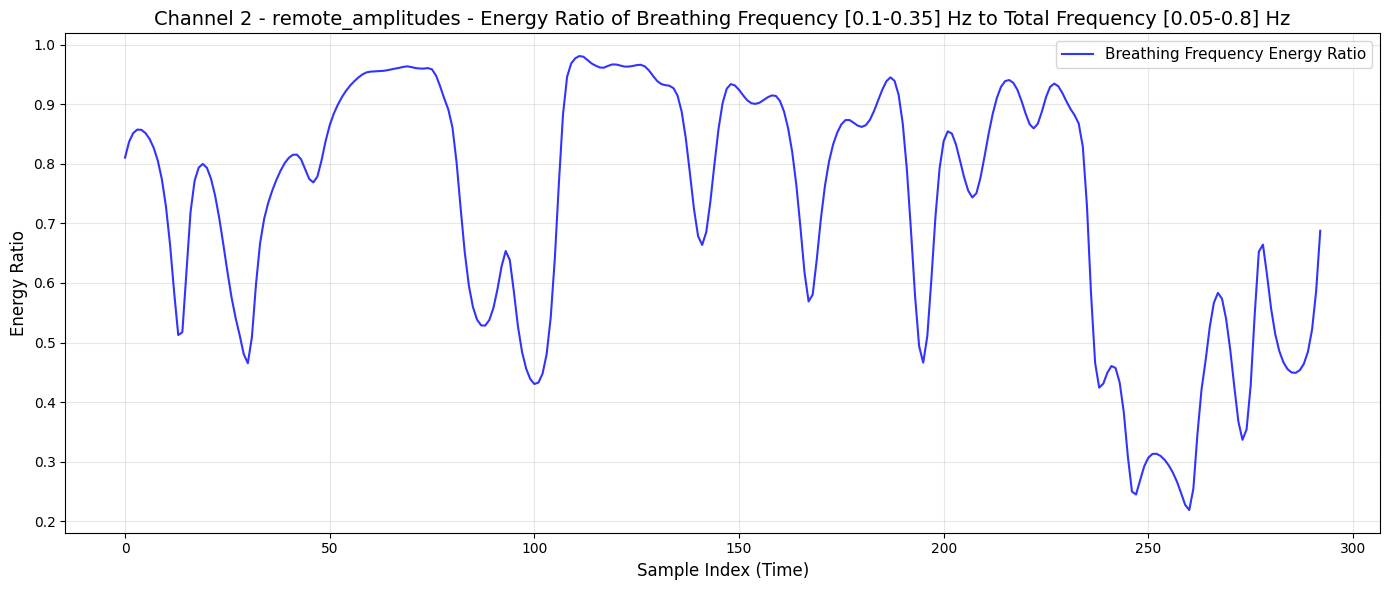


正在收集所有信道的能量占比数据（变量: remote_amplitudes）...
✓ 找到 72 个有效信道
时间窗数量范围: 184 - 345


C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\1002566896.py:224: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20')  # 使用tab20 colormap，支持20种不同颜色
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\1002566896.py:226: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20c')  # 如果信道数超过20，使用tab20c（支持更多颜色）


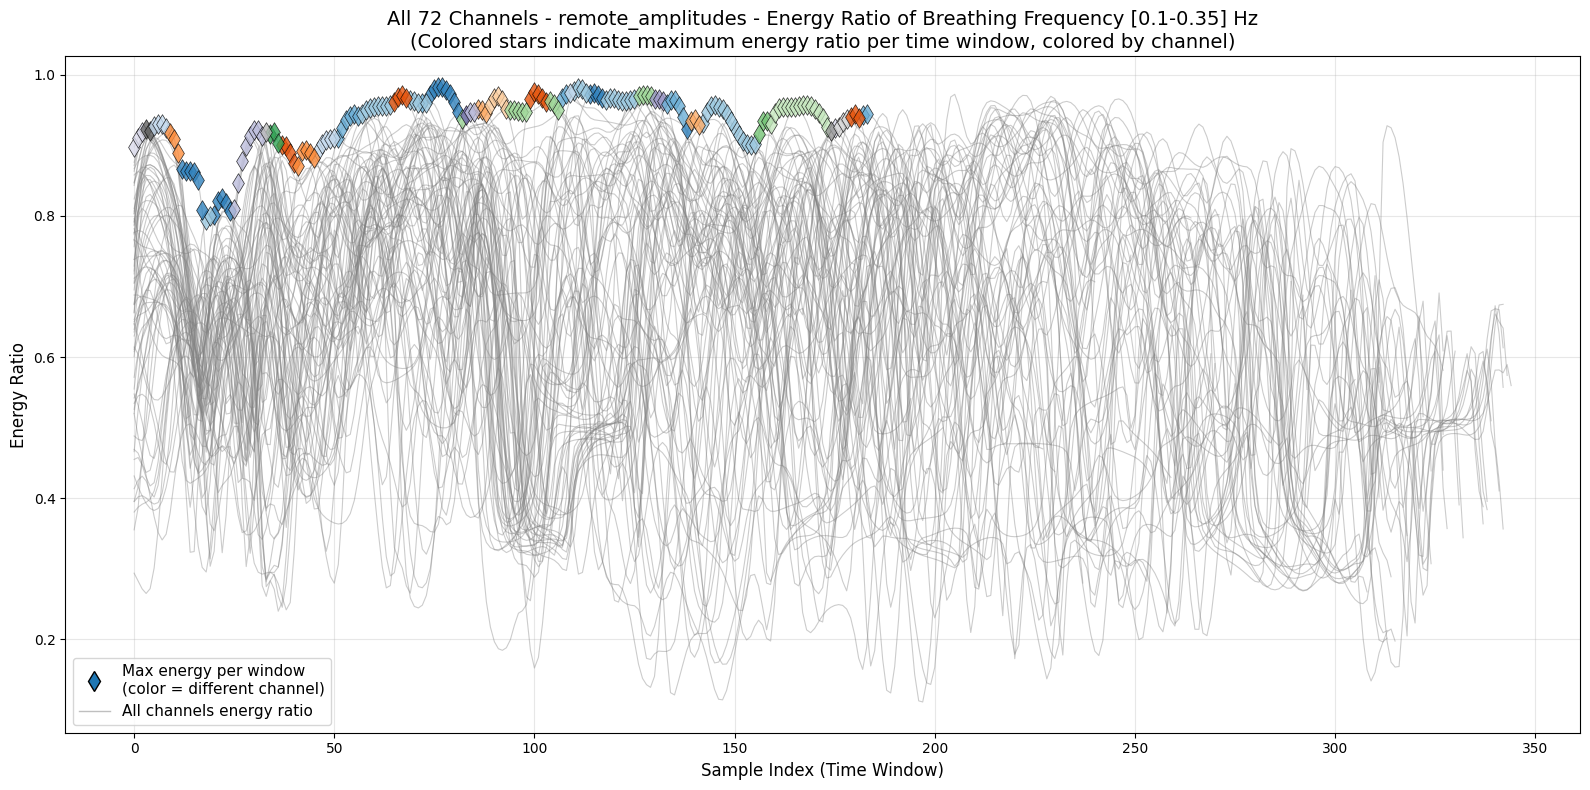


=== 所有信道能量占比统计（变量: remote_amplitudes）===
有效信道数: 72
时间窗数量: 184

作为能量占比最大的次数最多的前10个信道:
信道       次数       占比        
------------------------------
2        32       17.39     %
0        18       9.78      %
41       15       8.15      %
4        13       7.07      %
40       13       7.07      %
47       10       5.43      %
1        9        4.89      %
64       8        4.35      %
63       7        3.80      %
3        6        3.26      %


C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\1002566896.py:365: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_pool = cm.get_cmap('tab20').colors


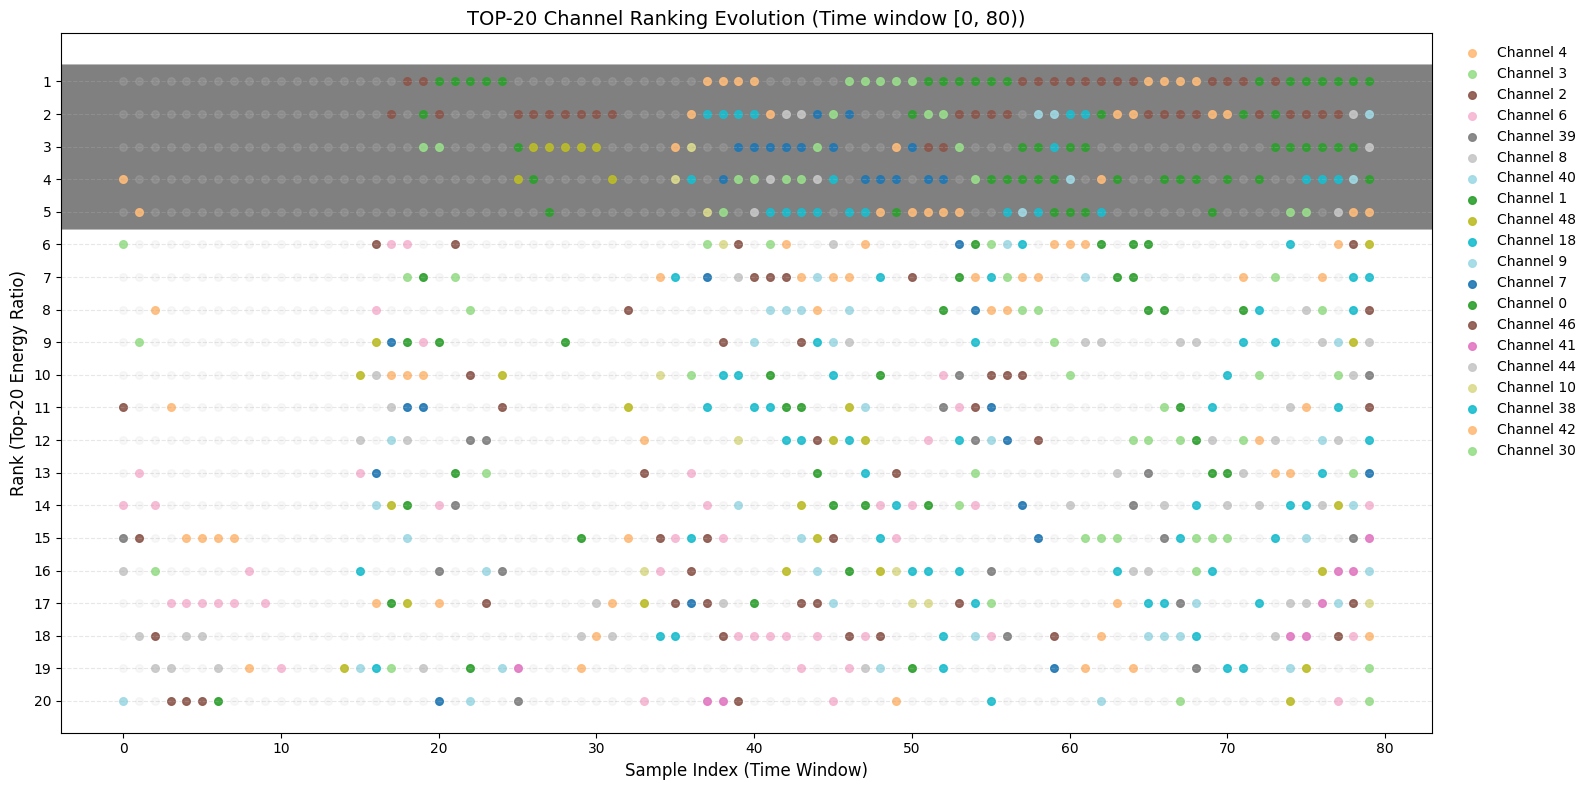

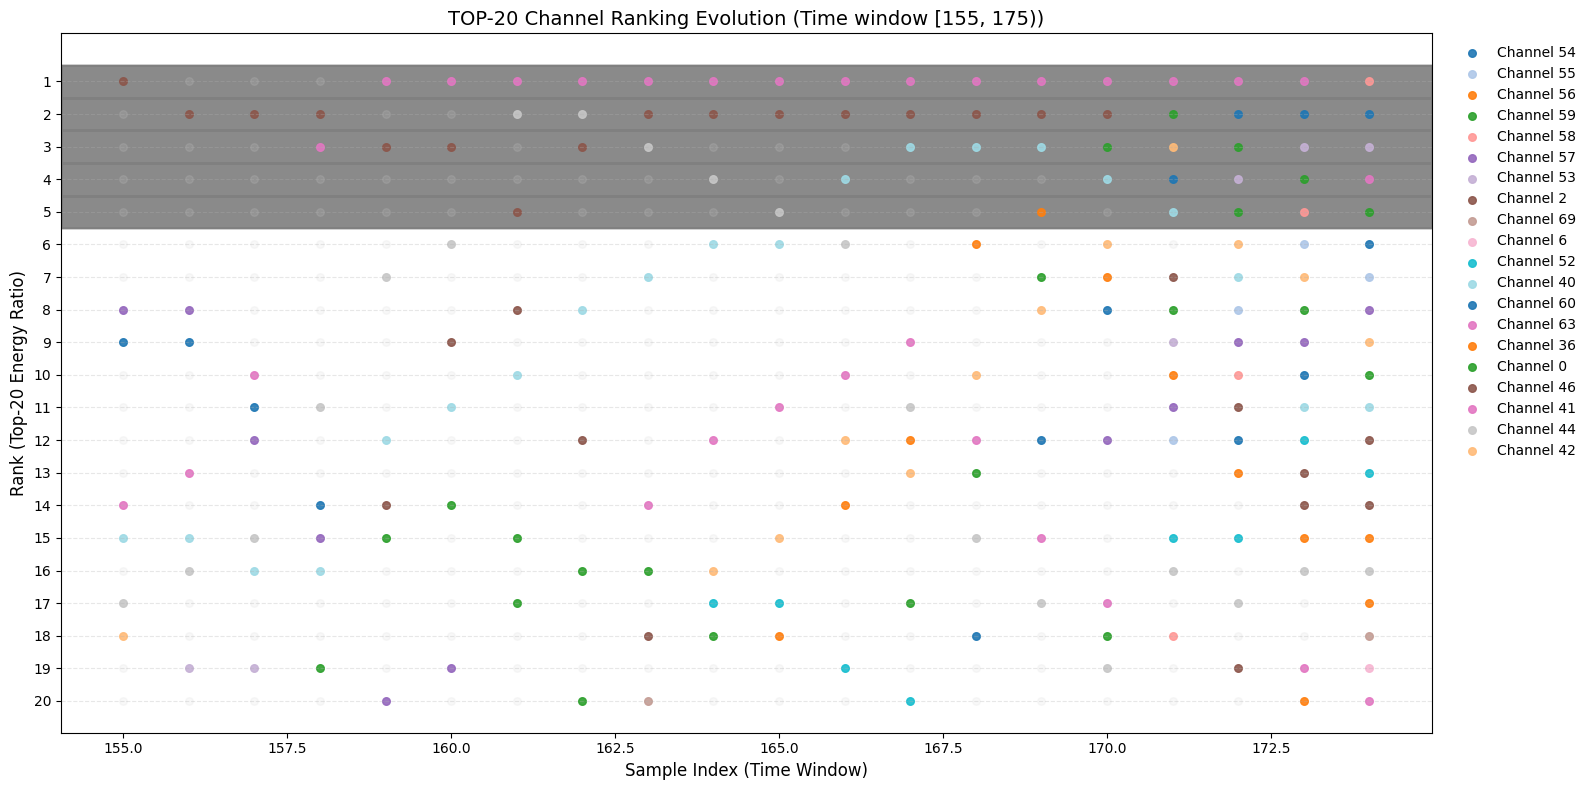

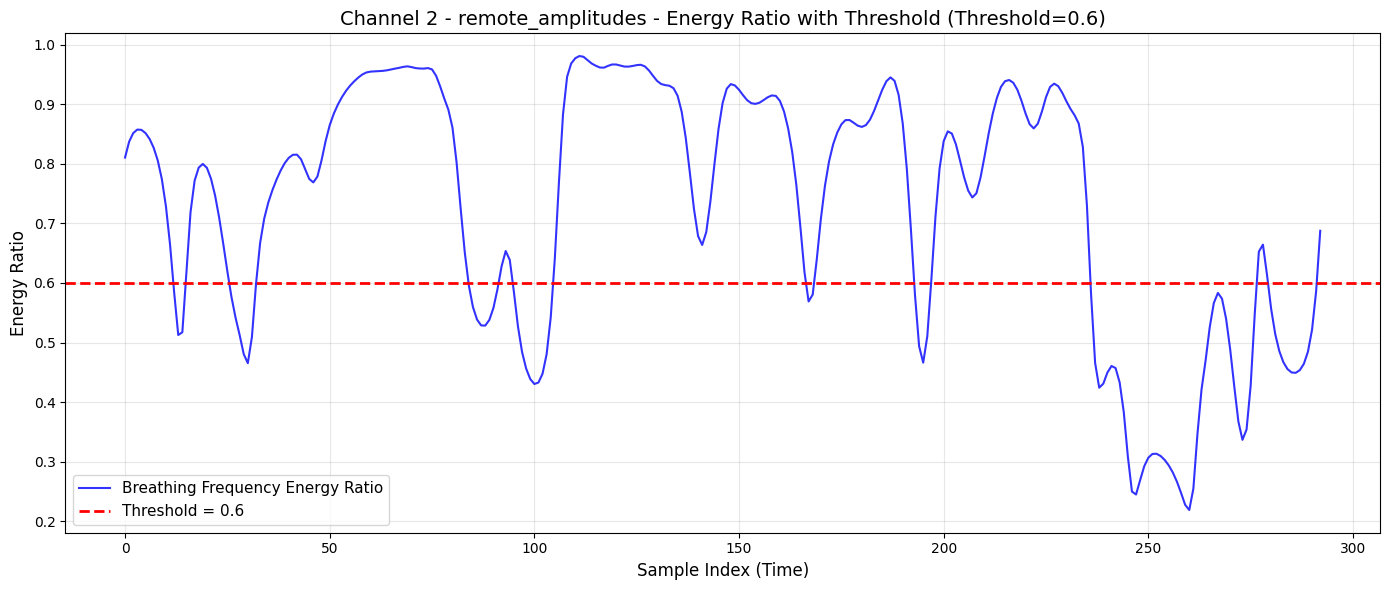


=== 阈值分析（阈值=0.6，仅用于 remote_amplitudes）===
阈值以上的样本数: 206 / 293 (70.3%)
阈值以下的样本数: 87 / 293 (29.7%)


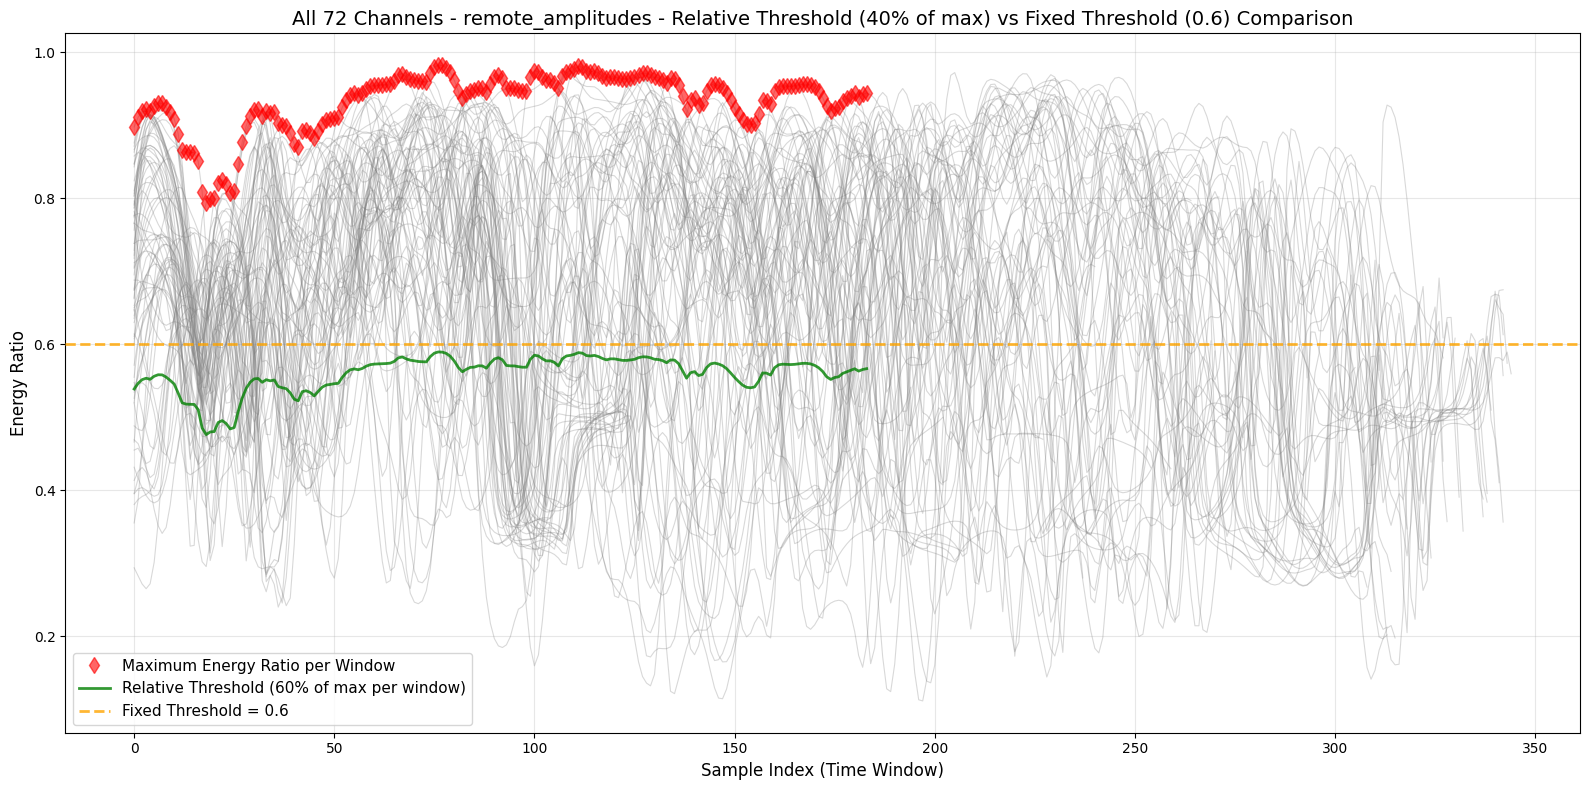


=== 相对阈值 vs 固定阈值对比分析 ===
相对阈值: 每个时间窗最大值的60%
固定阈值: 0.6

按时间窗统计（每个时间窗至少有一个信道超过阈值）:
  相对阈值: 184 / 184 个时间窗 (100.0%)
  固定阈值: 184 / 184 个时间窗 (100.0%)

按所有信道-时间窗组合统计:
  相对阈值: 9953 / 13248 个样本 (75.1%)
  固定阈值: 9158 / 13248 个样本 (69.1%)

相对阈值统计:
  平均值: 0.5599
  范围: [0.4761, 0.5895]
  固定阈值: 0.6000


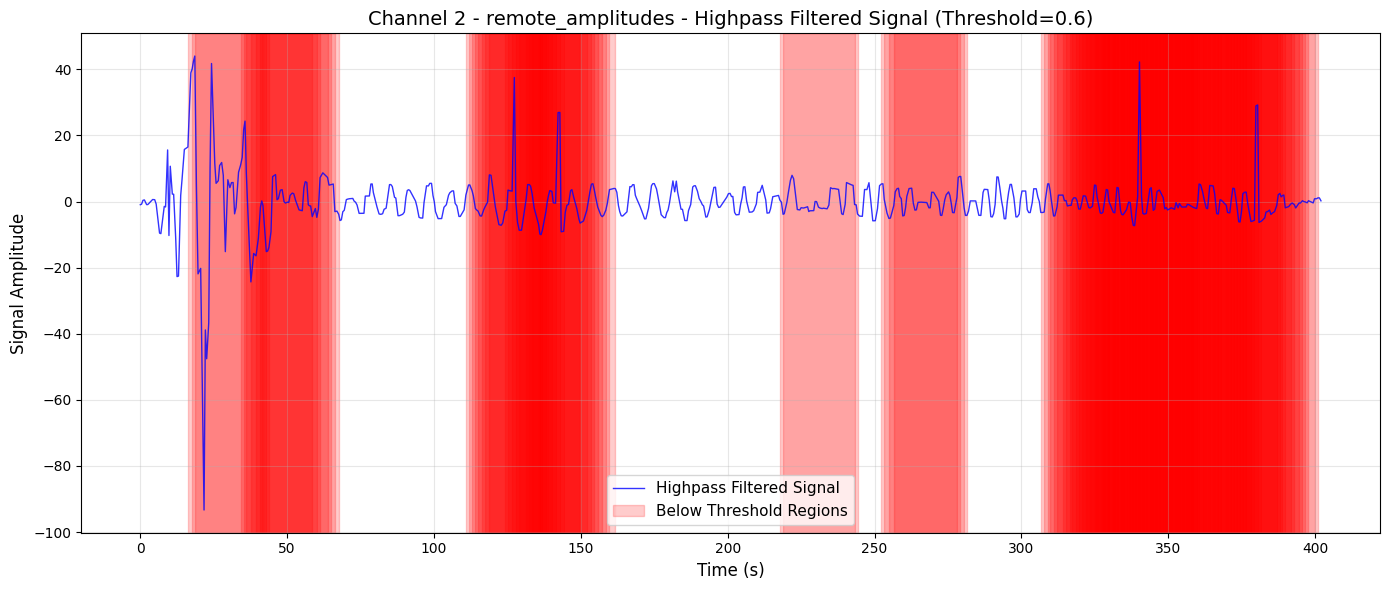

In [12]:
# 15-20秒时间窗，窗内计算呼吸【0.15-0.35】Hz这一范围占所有频率的能量比例
# 所有频率指【0.05-0.8】Hz,或着是上限设置为1/2 fs(2Hz)都可以。

# 参数设置
sampling_rate = 2.0  # Hz
window_length_sec = 20  # 时间窗长度（秒）
step_length_sec = 1  # 步长（秒）
window_length_samples = int(window_length_sec * sampling_rate)  # 20秒 = 40个样本点
step_length_samples = int(step_length_sec * sampling_rate)  # 1秒 = 2个样本点

# 呼吸频率范围
breath_freq_low = 0.1  # Hz
breath_freq_high = 0.35  # Hz
total_freq_low = 0.05  # Hz
total_freq_high = 0.8  # Hz

# # 选择通道和变量（用于展示）
# demo_channel = 0
# demo_variable = 'amplitudes'

# # 如果通道0不存在，使用第一个可用通道
# if demo_channel not in detrended_data and len(detrended_data) > 0:
#     demo_channel = list(detrended_data.keys())[0]
#     print(f"通道0不存在，使用通道 {demo_channel}")

# 存储所有通道和所有变量的分析结果
breathing_analysis_results = {}

# 遍历所有通道和所有变量，进行加窗和能量计算
print("开始对所有通道和所有变量进行加窗和能量计算...")
total_channels = len(detrended_data)
processed_channels = 0

for ch in detrended_data:
    breathing_analysis_results[ch] = {}
    ch_detrended = detrended_data[ch]
    
    # 遍历所有变量
    for var_name in ['amplitudes', 'phases', 'local_amplitudes', 'remote_amplitudes', 'local_phases', 'remote_phases']:
        if var_name in ch_detrended and 'detrended_order2' in ch_detrended[var_name]:
            # 获取高通滤波后的数据（使用order2）
            filtered_signal = ch_detrended[var_name]['detrended_order2']
            signal_length = len(filtered_signal)
            
            if signal_length < window_length_samples:
                # 信号太短，跳过
                continue
            
            # 对信号进行时间窗分割
            windowed_samples = []
            sample_indices = []
            
            start_idx = 0
            while start_idx + window_length_samples <= signal_length:
                # 提取一个时间窗
                window_data = filtered_signal[start_idx:start_idx + window_length_samples]
                
                # 应用Hanning窗
                hanning_window = np.hanning(len(window_data))
                windowed_data = window_data * hanning_window
                
                # 存储加窗后的样本
                windowed_samples.append(windowed_data)
                sample_indices.append(start_idx)
                
                # 移动到下一个窗口（步长为1秒）
                start_idx += step_length_samples
            
            # 对每个样本进行FFT并计算能量比例
            energy_ratios = []
            
            for i, windowed_data in enumerate(windowed_samples):
                # 计算FFT（使用rfft只计算正频率部分，更高效）
                fft_values = np.fft.rfft(windowed_data)
                fft_power = np.abs(fft_values) ** 2  # 功率谱
                
                # 计算频率轴（只包含正频率）
                fft_freq = np.fft.rfftfreq(len(windowed_data), 1.0 / sampling_rate)
                
                # 找到呼吸频率范围【0.15-0.35】Hz的索引
                breath_mask = (fft_freq >= breath_freq_low) & (fft_freq <= breath_freq_high)
                
                # 找到总频率范围【0.05-0.8】Hz的索引
                total_mask = (fft_freq >= total_freq_low) & (fft_freq <= total_freq_high)
                
                # 计算能量
                breath_energy = np.sum(fft_power[breath_mask])
                total_energy = np.sum(fft_power[total_mask])
                
                # 计算能量比例
                if total_energy > 0:
                    energy_ratio = breath_energy / total_energy
                else:
                    energy_ratio = 0.0
                
                energy_ratios.append(energy_ratio)
            
            # 存储该通道该变量的分析结果
            breathing_analysis_results[ch][var_name] = {
                'energy_ratios': np.array(energy_ratios),
                'windowed_samples': windowed_samples,
                'sample_indices': sample_indices,
                'filtered_signal': filtered_signal,
                'signal_length': signal_length
            }
    
    processed_channels += 1
    if processed_channels % 10 == 0 or processed_channels == total_channels:
        print(f"  已处理 {processed_channels}/{total_channels} 个通道...")

print(f"✓ 所有通道和变量的加窗和能量计算完成")


# 选择通道和变量（用于展示）
demo_channel = 2
demo_variable = 'remote_amplitudes'

# 如果通道0不存在，使用第一个可用通道
if demo_channel not in detrended_data and len(detrended_data) > 0:
    demo_channel = list(detrended_data.keys())[0]
    print(f"通道0不存在，使用通道 {demo_channel}")
    
# 检查demo_channel和demo_variable的数据是否存在
if demo_channel not in breathing_analysis_results or demo_variable not in breathing_analysis_results[demo_channel]:
    print(f"⚠️ 无法找到通道 {demo_channel} 的变量 {demo_variable}")
else:
    # 获取demo_variable的分析结果
    demo_results = breathing_analysis_results[demo_channel][demo_variable]
    breathing_energy_ratios = demo_results['energy_ratios']
    windowed_samples = demo_results['windowed_samples']
    sample_indices = demo_results['sample_indices']
    filtered_signal = demo_results['filtered_signal']
    signal_length = demo_results['signal_length']
    
    print(f"\n=== 展示通道 {demo_channel} 的变量 {demo_variable} ===")
    print(f"信号长度: {signal_length} 个样本点")
    print(f"时间窗长度: {window_length_sec}秒 ({window_length_samples}个样本点)")
    print(f"步长: {step_length_sec}秒 ({step_length_samples}个样本点)")
    print(f"✓ 共生成 {len(windowed_samples)} 个时间窗样本")
    print(f"✓ 能量比例计算完成，共 {len(breathing_energy_ratios)} 个样本")
    print(f"能量比例范围: [{np.min(breathing_energy_ratios):.4f}, {np.max(breathing_energy_ratios):.4f}]")
    print(f"平均能量比例: {np.mean(breathing_energy_ratios):.4f}")
    
    # 绘制能量占比图
    sample_numbers = np.arange(len(breathing_energy_ratios))
    time_axis = sample_numbers * step_length_sec  # 时间轴（秒）
    
    # 图1：能量占比曲线
    plt.figure(figsize=(14, 6))
    plt.plot(sample_numbers, breathing_energy_ratios, 'b-', linewidth=1.5, alpha=0.8, label='Breathing Frequency Energy Ratio')
    plt.xlabel('Sample Index (Time)', fontsize=12)
    plt.ylabel('Energy Ratio', fontsize=12)
    plt.title(f'Channel {demo_channel} - {demo_variable} - Energy Ratio of Breathing Frequency [{breath_freq_low}-{breath_freq_high}] Hz to Total Frequency [{total_freq_low}-{total_freq_high}] Hz', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()
    
    # 图1.5：所有72个信道的能量占比曲线 + 每个时间窗中能量占比最大的信号标记
    # 收集所有信道的能量占比数据（使用demo_variable）
    print(f"\n正在收集所有信道的能量占比数据（变量: {demo_variable}）...")
    all_channels_energy_ratios = {}
    valid_channels = []
    
    for ch in breathing_analysis_results:
        if demo_variable in breathing_analysis_results[ch]:
            energy_ratios = breathing_analysis_results[ch][demo_variable]['energy_ratios']
            all_channels_energy_ratios[ch] = energy_ratios
            valid_channels.append(ch)
    
    print(f"✓ 找到 {len(valid_channels)} 个有效信道")
    
    if len(valid_channels) > 0:
        # 确定所有信道中时间窗数量的最大值（用于对齐）
        max_windows = max(len(all_channels_energy_ratios[ch]) for ch in valid_channels)
        min_windows = min(len(all_channels_energy_ratios[ch]) for ch in valid_channels)
        
        print(f"时间窗数量范围: {min_windows} - {max_windows}")
        
        # 创建图形
        plt.figure(figsize=(16, 8))
        
        # 绘制所有信道的能量占比曲线
        for ch in valid_channels:
            energy_ratios = all_channels_energy_ratios[ch]
            ch_sample_numbers = np.arange(len(energy_ratios))
            plt.plot(ch_sample_numbers, energy_ratios, '-', linewidth=0.8, alpha=0.4, color='gray', label=None)
        
        # 在每个时间窗中找到能量占比最大的信道
        # 使用最小的时间窗数量，确保所有信道都有数据
        max_energy_channels = []  # 存储每个时间窗中能量占比最大的信道
        max_energy_values = []    # 存储每个时间窗中的最大能量占比值
        
        for window_idx in range(min_windows):
            max_energy = -1
            max_ch = None
            
            for ch in valid_channels:
                if window_idx < len(all_channels_energy_ratios[ch]):
                    energy = all_channels_energy_ratios[ch][window_idx]
                    if energy > max_energy:
                        max_energy = energy
                        max_ch = ch
            
            if max_ch is not None:
                max_energy_channels.append(max_ch)
                max_energy_values.append(max_energy)
            else:
                max_energy_channels.append(None)
                max_energy_values.append(0)
        
        # 绘制每个时间窗中能量占比最大的点，根据所属信道使用不同颜色
        max_sample_numbers = np.arange(len(max_energy_values))
        
        # 为每个信道分配颜色（使用colormap）
        import matplotlib.cm as cm
        unique_channels = sorted(set(max_energy_channels))
        if None in unique_channels:
            unique_channels.remove(None)
        n_unique_channels = len(unique_channels)
        
        if n_unique_channels > 0:
            # 使用colormap为每个信道分配颜色
            colormap = cm.get_cmap('tab20')  # 使用tab20 colormap，支持20种不同颜色
            if n_unique_channels > 20:
                colormap = cm.get_cmap('tab20c')  # 如果信道数超过20，使用tab20c（支持更多颜色）
            
            channel_colors = {}
            for idx, ch in enumerate(unique_channels):
                channel_colors[ch] = colormap(idx % colormap.N)
            
            # 按信道分组绘制标记点
            for ch in unique_channels:
                ch_indices = [i for i, max_ch in enumerate(max_energy_channels) if max_ch == ch]
                if ch_indices:
                    ch_x = [max_sample_numbers[i] for i in ch_indices]
                    ch_y = [max_energy_values[i] for i in ch_indices]
                    plt.scatter(ch_x, ch_y, c=[channel_colors[ch]], marker='d', s=100, alpha=0.8, 
                              label=f'Channel {ch}', zorder=10, edgecolors='black', linewidths=0.5)
        
        # 添加图例和标签
        plt.xlabel('Sample Index (Time Window)', fontsize=12)
        plt.ylabel('Energy Ratio', fontsize=12)
        plt.title(f'All {len(valid_channels)} Channels - {demo_variable} - Energy Ratio of Breathing Frequency [{breath_freq_low}-{breath_freq_high}] Hz\n(Colored stars indicate maximum energy ratio per time window, colored by channel)', fontsize=14)
        plt.grid(True, alpha=0.3)
        # plt.legend(fontsize=11)

        from matplotlib.lines import Line2D

        legend_elements = [
            Line2D([0], [0],
                marker='d',
                color='w',
                label='Max energy per window\n(color = different channel)',
                markerfacecolor='tab:blue',
                markeredgecolor='black',
                markersize=10),
            Line2D([0], [0],
                color='gray',
                lw=1,
                alpha=0.5,
                label='All channels energy ratio')
        ]

        plt.legend(handles=legend_elements,
                loc='best',
                fontsize=11,
                frameon=True,)



        plt.tight_layout()
        plt.show()
        
        # 打印统计信息
        print(f"\n=== 所有信道能量占比统计（变量: {demo_variable}）===")
        print(f"有效信道数: {len(valid_channels)}")
        print(f"时间窗数量: {min_windows}")
        
        # 统计每个信道作为最大值的次数
        channel_max_count = {}
        for ch in valid_channels:
            channel_max_count[ch] = 0
        
        for max_ch in max_energy_channels:
            if max_ch is not None:
                channel_max_count[max_ch] = channel_max_count.get(max_ch, 0) + 1
        
        # 找出作为最大值次数最多的前10个信道
        sorted_channels = sorted(channel_max_count.items(), key=lambda x: x[1], reverse=True)
        print(f"\n作为能量占比最大的次数最多的前10个信道:")
        print(f"{'信道':<8} {'次数':<8} {'占比':<10}")
        print("-" * 30)
        for ch, count in sorted_channels[:10]:
            percentage = count / len(max_energy_channels) * 100 if len(max_energy_channels) > 0 else 0
            print(f"{ch:<8} {count:<8} {percentage:<10.2f}%")
    
    # 图 1.5.1 TOP 10 信道变化
    # top_k = 10
    # top_channels = [ch for ch, _ in sorted_channels[:top_k]]
    # # import numpy as np

    # n_windows = len(max_energy_channels)
    # top_index = {ch: i for i, ch in enumerate(top_channels)}

    # # 初始化为 NaN（表示没有赢）
    # winner_matrix = np.full((top_k, n_windows), np.nan)

    # for t, ch in enumerate(max_energy_channels):
    #     if ch in top_index:
    #         winner_matrix[top_index[ch], t] = 1

    # plt.figure(figsize=(16, 4))

    # for i, ch in enumerate(top_channels):
    #     win_times = np.where(~np.isnan(winner_matrix[i]))[0]
    #     plt.scatter(
    #         win_times,
    #         np.full_like(win_times, i),
    #         s=25,
    #         marker='s',
    #         label=f'Channel {ch}'
    #     )

    # plt.yticks(
    #     ticks=range(top_k),
    #     labels=[f'Channel {ch}' for ch in top_channels]
    # )

    # plt.xlabel('Sample Index (Time Window)', fontsize=12)
    # plt.ylabel('Top-10 Channels (ranked)', fontsize=12)
    # plt.title(
    #     'Temporal distribution of TOP-10 channels\n'
    #     '(channel wins per time window)',
    #     fontsize=13
    # )

    # plt.grid(axis='x', alpha=0.2)
    # plt.tight_layout()
    # plt.show()

    # 1.5.2 TOP10排名变化图

    top_k = 20
    rankings = []  # list of dicts: [{channel: rank}, ...]

    for t in range(min_windows):
        window_energy = []

        for ch in valid_channels:
            if t < len(all_channels_energy_ratios[ch]):
                window_energy.append((ch, all_channels_energy_ratios[ch][t]))

        # 按能量从大到小排序
        window_energy.sort(key=lambda x: x[1], reverse=True)

        # 取 TOP‑10
        top = window_energy[:top_k]

        # 记录排名（1 是第一名）
        rankings.append({ch: rank + 1 for rank, (ch, _) in enumerate(top)})

    # import matplotlib.cm as cm

    color_pool = cm.get_cmap('tab20').colors
    channel_color = {}
    color_idx = 0

    def get_color(ch):
        global color_idx
        if ch not in channel_color:
            channel_color[ch] = color_pool[color_idx % len(color_pool)]
            color_idx += 1
        return channel_color[ch]

    # # import numpy as np

    time_axis = np.arange(len(rankings))
    channel_ranks = {}  # ch -> list of rank or NaN

    for t, rank_dict in enumerate(rankings):
        for ch, r in rank_dict.items():
            if ch not in channel_ranks:
                channel_ranks[ch] = [np.nan] * len(rankings)
            channel_ranks[ch][t] = r

    last_ranking = rankings[-1]
    final_top10 = set(last_ranking.keys())


    # 1.5.3 分段排名变化

    def plot_bump_segment(
        rankings,
        channel_ranks,
        start,
        end,
        title_suffix
    ):
        plt.figure(figsize=(16, 8))

        # 当前时间段
        time_seg = np.arange(start, end)

        # 当前段最后一帧的 TOP-10（决定 legend）
        final_ranking = rankings[end - 1]
        final_top10 = set(final_ranking.keys())

        for ch, ranks in channel_ranks.items():
            seg_ranks = np.array(ranks[start:end])

            if np.all(np.isnan(seg_ranks)):
                continue

            color = get_color(ch)

            label = f'Channel {ch}' if ch in final_top10 else None

            # plt.plot(
            #     time_seg,
            #     seg_ranks,
            #     '-o',
            #     linewidth=2,
            #     markersize=4,
            #     alpha=0.85 if ch in final_top10 else 0.25,
            #     color=color,
            #     label=label
            # )
            # plt.scatter(
            #     time_seg,
            #     seg_ranks,
            #     s=25,
            #     alpha=0.85 if ch in final_top10 else 0.25,
            #     color=color,
            #     label=label
            # )
            highlight = ch in final_top10

            plt.scatter(
                time_seg,
                seg_ranks,
                s=30,
                alpha=0.9 if highlight else 0.15,
                color=color if highlight else 'lightgray',
                label=label
            )
            for r in range(1, 6):  # 只强调前 5 名
                plt.axhspan(r - 0.5, r + 0.5,
                            color='gray',
                            alpha=0.04,
                            zorder=0)

        plt.gca().invert_yaxis()
        plt.yticks(range(1, top_k + 1))
        plt.xlabel('Sample Index (Time Window)', fontsize=12)
        plt.ylabel(f'Rank (Top-{top_k} Energy Ratio)', fontsize=12)
        plt.title(
            f'TOP-{top_k} Channel Ranking Evolution ({title_suffix})',
            fontsize=14
        )

        plt.grid(True, axis='y', linestyle='--', alpha=0.3)
        plt.legend(
            loc='upper left',
            bbox_to_anchor=(1.01, 1),
            fontsize=10,
            frameon=False
        )

        plt.tight_layout()
        plt.show()

    start = 0
    end = 80
    end_safe = min(end, len(rankings))
    title_suffix = f'Time window [{start}, {end_safe})'
    plot_bump_segment(
        rankings,
        channel_ranks,
        start=start,
        end=end_safe,
        title_suffix=title_suffix
    )
    start=155
    end = 175
    end_safe = min(end, len(rankings))
    title_suffix = f'Time window [{start}, {end_safe})'
    plot_bump_segment(
        rankings,
        channel_ranks,
        start=start,
        end=end_safe,
        title_suffix=title_suffix
    )

    # 手动指定阈值（只用于demo_variable）
    threshold = 0.6
    
    # 图2：能量占比曲线 + 阈值线
    plt.figure(figsize=(14, 6))
    plt.plot(sample_numbers, breathing_energy_ratios, 'b-', linewidth=1.5, alpha=0.8, label='Breathing Frequency Energy Ratio')
    plt.axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold = {threshold}')
    plt.xlabel('Sample Index (Time)', fontsize=12)
    plt.ylabel('Energy Ratio', fontsize=12)
    plt.title(f'Channel {demo_channel} - {demo_variable} - Energy Ratio with Threshold (Threshold={threshold})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()
    
    # 统计阈值以上的样本数量
    above_threshold = np.sum(breathing_energy_ratios >= threshold)
    below_threshold = len(breathing_energy_ratios) - above_threshold
    
    print(f"\n=== 阈值分析（阈值={threshold}，仅用于 {demo_variable}）===")
    print(f"阈值以上的样本数: {above_threshold} / {len(breathing_energy_ratios)} ({above_threshold/len(breathing_energy_ratios)*100:.1f}%)")
    print(f"阈值以下的样本数: {below_threshold} / {len(breathing_energy_ratios)} ({below_threshold/len(breathing_energy_ratios)*100:.1f}%)")
    
    # 图2.5：相对阈值（40%最大能量值）vs 固定阈值（0.6）对比
    # 使用所有信道的最大能量值来计算相对阈值
    # 如果图1.5已经计算了这些变量，直接使用；否则重新计算
    if len(valid_channels) > 0:
        # 检查是否已经计算了max_energy_values
        if 'max_energy_values' not in locals() or len(max_energy_values) == 0:
            # 重新计算max_energy_values
            if 'min_windows' not in locals():
                min_windows = min(len(all_channels_energy_ratios[ch]) for ch in valid_channels)
            
            max_energy_values = []
            for window_idx in range(min_windows):
                max_energy = -1
                for ch in valid_channels:
                    if window_idx < len(all_channels_energy_ratios[ch]):
                        energy = all_channels_energy_ratios[ch][window_idx]
                        if energy > max_energy:
                            max_energy = energy
                max_energy_values.append(max_energy if max_energy > 0 else 0)
        
        if len(max_energy_values) > 0:
            # 计算相对阈值：每个时间窗最大值的百分比%
            relative_threshold_ratio = 0.6
            relative_thresholds = [max_val * relative_threshold_ratio for max_val in max_energy_values]
            
            # 创建图形
            plt.figure(figsize=(16, 8))
            
            # 绘制所有信道的能量占比曲线（灰色背景）
            for ch in valid_channels:
                energy_ratios = all_channels_energy_ratios[ch]
                ch_sample_numbers = np.arange(len(energy_ratios))
                plt.plot(ch_sample_numbers, energy_ratios, '-', linewidth=0.8, alpha=0.3, color='gray', label=None)
            
            # 绘制每个时间窗的最大能量值（红色星号）
            max_sample_numbers = np.arange(len(max_energy_values))
            plt.plot(max_sample_numbers, max_energy_values, 'rd', markersize=8, alpha=0.6, 
                    label=f'Maximum Energy Ratio per Window', zorder=5)
            
            # 绘制相对阈值线（每个时间窗最大值的X0%）
            plt.plot(max_sample_numbers, relative_thresholds, 'g-', linewidth=2, alpha=0.8, 
                    label=f'Relative Threshold ({relative_threshold_ratio*100:.0f}% of max per window)', zorder=6)
            
            # 绘制固定阈值线（0.6）
            fixed_threshold = 0.6
            plt.axhline(y=fixed_threshold, color='orange', linestyle='--', linewidth=2, alpha=0.8, 
                    label=f'Fixed Threshold = {fixed_threshold}', zorder=7)
            
            # 添加图例和标签
            plt.xlabel('Sample Index (Time Window)', fontsize=12)
            plt.ylabel('Energy Ratio', fontsize=12)
            plt.title(f'All {len(valid_channels)} Channels - {demo_variable} - Relative Threshold (40% of max) vs Fixed Threshold (0.6) Comparison', fontsize=14)
            plt.grid(True, alpha=0.3)
            plt.legend(fontsize=11, loc='best')
            plt.tight_layout()
            plt.show()
        
            # 统计两种阈值下的样本数量
            # 对于相对阈值，需要检查每个时间窗中是否有信道超过该时间窗的相对阈值
            # 对于固定阈值，检查每个时间窗中是否有信道超过固定阈值
            relative_above_count = 0
            fixed_above_count = 0
            total_windows = len(max_energy_values)
            
            for window_idx in range(min_windows):
                # 检查该时间窗中是否有信道超过相对阈值
                relative_thresh = relative_thresholds[window_idx]
                for ch in valid_channels:
                    if window_idx < len(all_channels_energy_ratios[ch]):
                        if all_channels_energy_ratios[ch][window_idx] >= relative_thresh:
                            relative_above_count += 1
                            break  # 只要有一个信道超过就计数
                
                # 检查该时间窗中是否有信道超过固定阈值
                for ch in valid_channels:
                    if window_idx < len(all_channels_energy_ratios[ch]):
                        if all_channels_energy_ratios[ch][window_idx] >= fixed_threshold:
                            fixed_above_count += 1
                            break  # 只要有一个信道超过就计数
            
            # 另一种统计方式：统计所有信道-时间窗组合中超过阈值的数量
            relative_above_all = 0
            fixed_above_all = 0
            total_samples = 0
            
            for window_idx in range(min_windows):
                for ch in valid_channels:
                    if window_idx < len(all_channels_energy_ratios[ch]):
                        total_samples += 1
                        energy = all_channels_energy_ratios[ch][window_idx]
                        if energy >= relative_thresholds[window_idx]:
                            relative_above_all += 1
                        if energy >= fixed_threshold:
                            fixed_above_all += 1
            
            print(f"\n=== 相对阈值 vs 固定阈值对比分析 ===")
            print(f"相对阈值: 每个时间窗最大值的{relative_threshold_ratio*100:.0f}%")
            print(f"固定阈值: {fixed_threshold}")
            print(f"\n按时间窗统计（每个时间窗至少有一个信道超过阈值）:")
            print(f"  相对阈值: {relative_above_count} / {total_windows} 个时间窗 ({relative_above_count/total_windows*100:.1f}%)")
            print(f"  固定阈值: {fixed_above_count} / {total_windows} 个时间窗 ({fixed_above_count/total_windows*100:.1f}%)")
            print(f"\n按所有信道-时间窗组合统计:")
            print(f"  相对阈值: {relative_above_all} / {total_samples} 个样本 ({relative_above_all/total_samples*100:.1f}%)")
            print(f"  固定阈值: {fixed_above_all} / {total_samples} 个样本 ({fixed_above_all/total_samples*100:.1f}%)")
            
            # 计算相对阈值的平均值和范围
            avg_relative_threshold = np.mean(relative_thresholds)
            min_relative_threshold = np.min(relative_thresholds)
            max_relative_threshold = np.max(relative_thresholds)
            print(f"\n相对阈值统计:")
            print(f"  平均值: {avg_relative_threshold:.4f}")
            print(f"  范围: [{min_relative_threshold:.4f}, {max_relative_threshold:.4f}]")
            print(f"  固定阈值: {fixed_threshold:.4f}")
    
    # 图3：高通滤波后的信号 + 低于阈值的区间背景标记
    # 获取时间轴
    timestamps_ms = all_channels_data[demo_channel]['timestamps_ms']
    if len(timestamps_ms) > 0:
        time_sec = (timestamps_ms - timestamps_ms[0]) / 1000.0
    else:
        time_sec = np.arange(len(filtered_signal)) / sampling_rate
    
    # 确保时间轴长度与信号长度匹配
    if len(time_sec) != len(filtered_signal):
        time_sec = np.arange(len(filtered_signal)) / sampling_rate
    
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    
    # 绘制高通滤波后的信号
    ax.plot(time_sec, filtered_signal, 'b-', linewidth=1.0, alpha=0.8, label='Highpass Filtered Signal')
    
    # 标记低于阈值的区间
    # 找到所有低于阈值的样本
    below_threshold_samples = np.where(breathing_energy_ratios < threshold)[0]
    
    # 为每个低于阈值的样本绘制背景区域
    label_added = False
    for sample_idx in below_threshold_samples:
        # 使用sample_indices获取该样本的起始索引
        if sample_idx < len(sample_indices):
            start_idx = sample_indices[sample_idx]
            end_idx = start_idx + window_length_samples
            
            # 确保索引在有效范围内
            if end_idx <= len(time_sec):
                start_time = time_sec[start_idx]
                end_time = time_sec[end_idx - 1] if end_idx > 0 else time_sec[-1]
            else:
                # 如果超出范围，使用最后一个时间点
                start_time = time_sec[start_idx] if start_idx < len(time_sec) else time_sec[-1]
                end_time = time_sec[-1]
        else:
            # 如果sample_indices不可用，使用近似计算
            start_time = sample_idx * step_length_sec
            end_time = start_time + window_length_sec
            start_time = max(start_time, time_sec[0])
            end_time = min(end_time, time_sec[-1])
        
        # 绘制浅红色背景区域
        if not label_added:
            ax.axvspan(start_time, end_time, alpha=0.2, color='red', label='Below Threshold Regions')
            label_added = True
        else:
            ax.axvspan(start_time, end_time, alpha=0.2, color='red')
    
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Signal Amplitude', fontsize=12)
    ax.set_title(f'Channel {demo_channel} - {demo_variable} - Highpass Filtered Signal (Threshold={threshold})', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    plt.tight_layout()
    plt.show()


# add.3 带通滤波
保留呼吸
- 通带：
  - **0.15 – 0.35 Hz**
  - 0.15稍大，换0.1
- 阶数：
  - **2 阶 Butterworth**
- 滤波方式：
  - 零相位

✓ Using bandpass_filter_zero_phase from utils.signal_algrithom

Applying bandpass filter to windowed data...
Sampling rate: 2.0 Hz
Passband: 0.1 - 0.35 Hz
Threshold for energy ratio: 0.6
开始对所有通道和所有变量进行带通滤波...
已处理 10/72 个通道...
已处理 20/72 个通道...
已处理 30/72 个通道...
已处理 40/72 个通道...
已处理 50/72 个通道...
已处理 60/72 个通道...
已处理 70/72 个通道...
已处理 72/72 个通道...
✓ Bandpass filtering and frequency estimation completed for all channels and variables


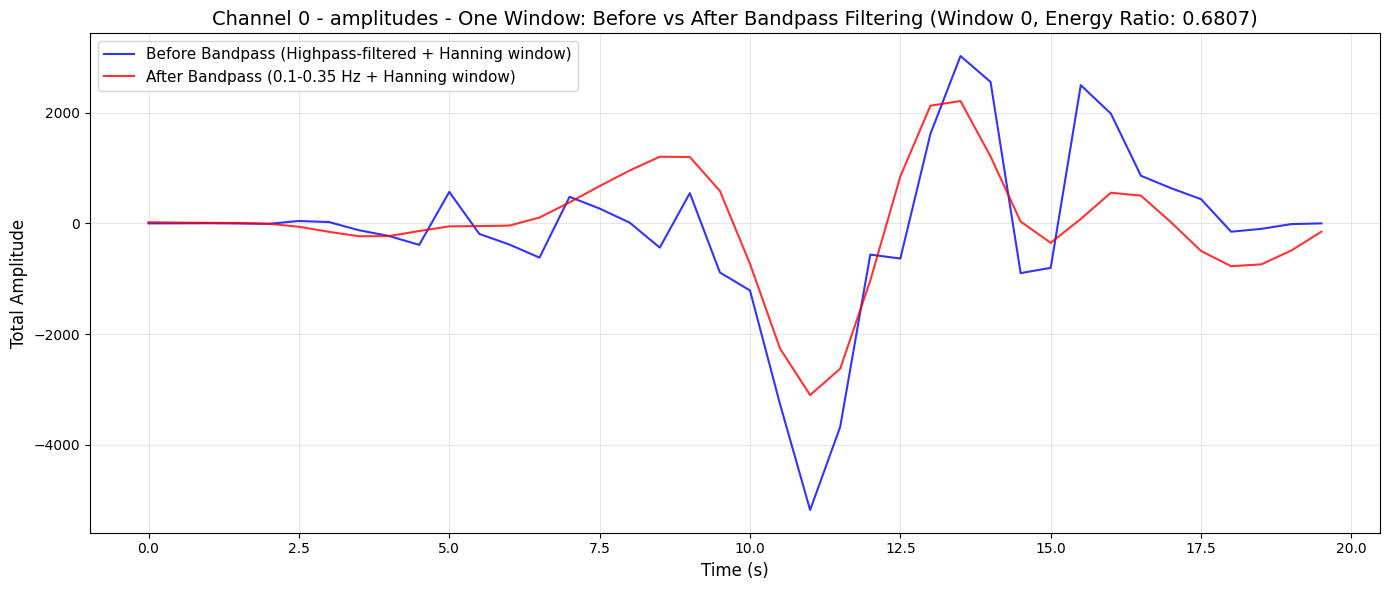

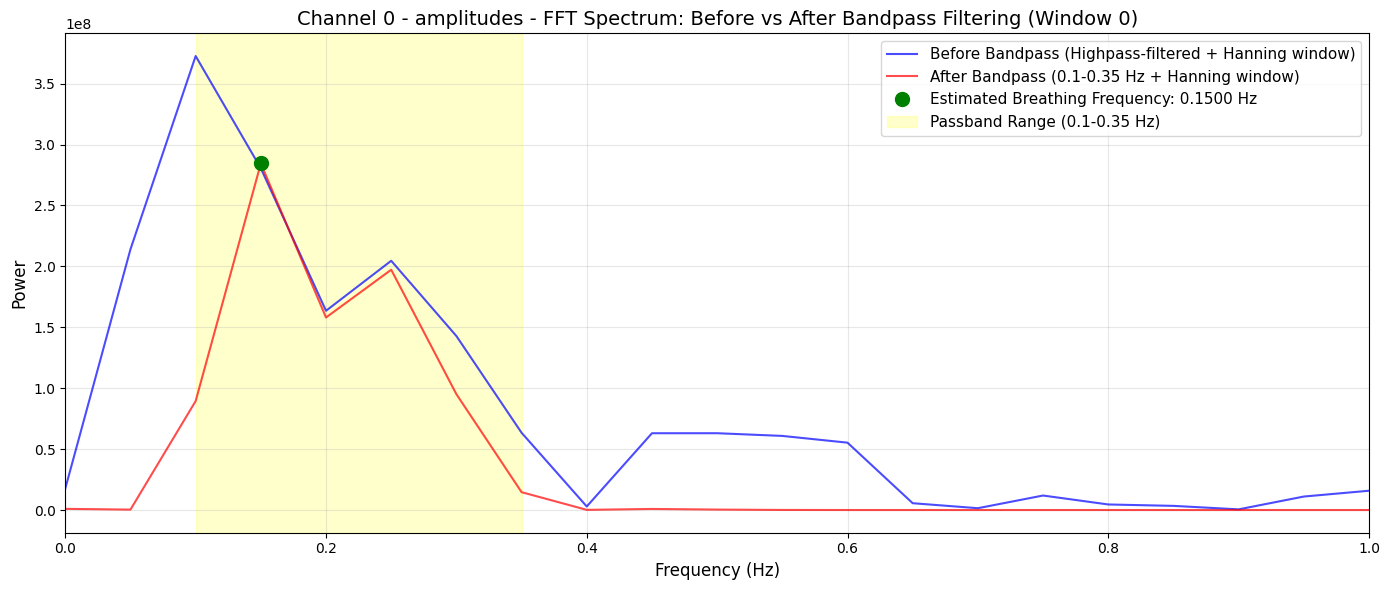

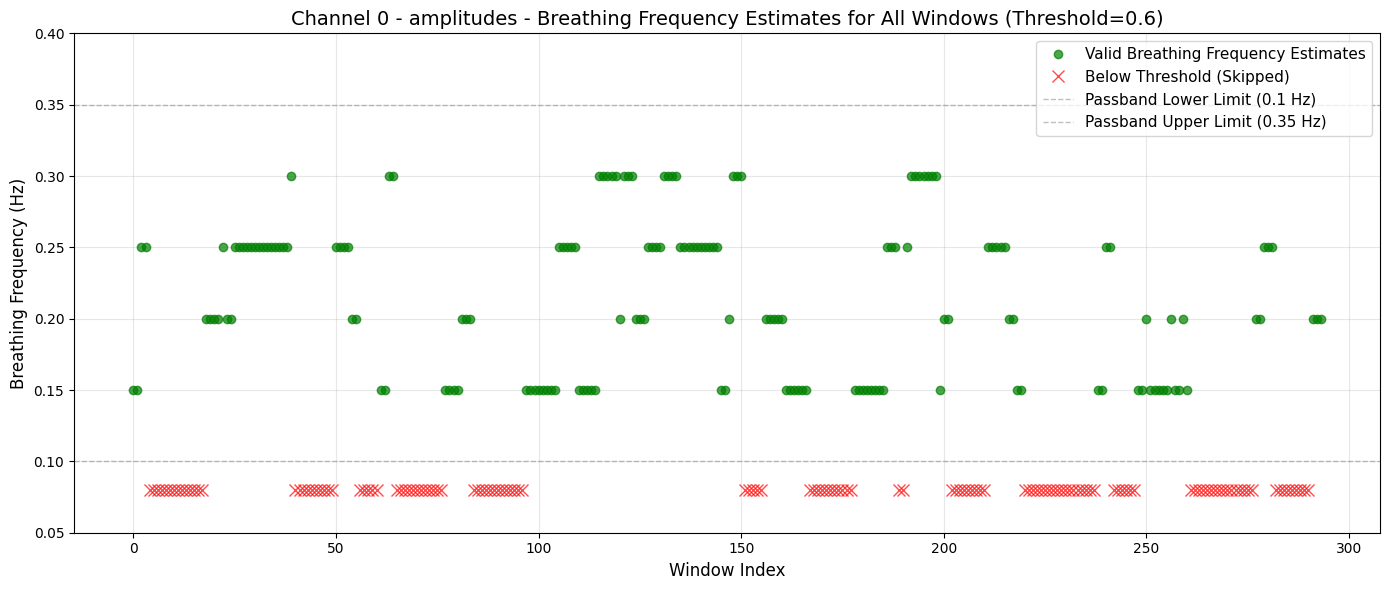


=== Channel 0 - Total Amplitude - Breathing Frequency Statistics ===
Total windows: 294
Valid windows (above threshold): 164 (55.8%)
Invalid windows (below threshold): 130 (44.2%)

Valid breathing frequency estimates:
  Mean: 0.2159 Hz
  Std: 0.0537 Hz
  Min: 0.1500 Hz
  Max: 0.3000 Hz


In [13]:
# Apply bandpass filter to windowed data (only for windows with energy ratio above threshold)
# Use the windowed data from breathing_analysis_results

# Import bandpass filter function from utils
try:
    from utils.signal_algrithom import bandpass_filter_zero_phase
    print("✓ Using bandpass_filter_zero_phase from utils.signal_algrithom")
except ImportError:
    print("⚠️ Import failed, using sig_algm")

# Parameters
sampling_rate = 2.0  # Hz (2 Hz sampling rate as mentioned)
lowcut = 0.1  # Hz (low cutoff frequency for breathing range)
highcut = 0.35  # Hz (high cutoff frequency for breathing range)
threshold = 0.6  # Same threshold as used in breathing detection

print(f"\nApplying bandpass filter to windowed data...")
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Passband: {lowcut} - {highcut} Hz")
print(f"Threshold for energy ratio: {threshold}")

# Check if breathing_analysis_results exists
if 'breathing_analysis_results' not in globals():
    print("⚠️ breathing_analysis_results not found. Please run the breathing detection section first.")
else:
    # Store bandpass filtered results and breathing frequency estimates
    bandpass_results = {}
    breathing_freq_estimates = {}
    
    # Process all channels and variables
    print("开始对所有通道和所有变量进行带通滤波...")
    total_channels = len(detrended_data)
    processed_channels = 0
    for ch in breathing_analysis_results:
        bandpass_results[ch] = {}
        breathing_freq_estimates[ch] = {}
        
        for var_name in breathing_analysis_results[ch]:
            energy_ratios = breathing_analysis_results[ch][var_name]['energy_ratios']
            windowed_samples = breathing_analysis_results[ch][var_name]['windowed_samples']
            
            # Apply bandpass filter to each window (only if energy ratio >= threshold)
            bandpass_filtered_windows = []
            breathing_freqs = []  # Store breathing frequency estimates for each window
            
            for i, (windowed_data, energy_ratio) in enumerate(zip(windowed_samples, energy_ratios)):
                if energy_ratio >= threshold:
                    # Apply bandpass filter directly to the windowed data
                    # Note: windowed_data is already windowed with Hanning window
                    # We apply bandpass filter to the windowed data
                    bandpass_windowed = sig_algm.bandpass_filter_zero_phase(
                        windowed_data,
                        lowcut=lowcut,
                        highcut=highcut,
                        sampling_rate=sampling_rate,
                        order=2
                    )
                    
                    bandpass_filtered_windows.append(bandpass_windowed)
                    
                    # Use FFT to estimate breathing frequency (find frequency with maximum energy)
                    fft_values = np.fft.rfft(bandpass_windowed)
                    fft_power = np.abs(fft_values) ** 2
                    fft_freq = np.fft.rfftfreq(len(bandpass_windowed), 1.0 / sampling_rate)
                    
                    # Find frequency range within [lowcut, highcut]
                    freq_mask = (fft_freq >= lowcut) & (fft_freq <= highcut)
                    if np.any(freq_mask):
                        # Find frequency with maximum power in the passband
                        max_power_idx = np.argmax(fft_power[freq_mask])
                        # Get the actual index in fft_freq
                        freq_indices = np.where(freq_mask)[0]
                        max_freq_idx = freq_indices[max_power_idx]
                        breathing_freq = fft_freq[max_freq_idx]
                    else:
                        breathing_freq = np.nan
                    
                    breathing_freqs.append(breathing_freq)
                else:
                    # Energy ratio below threshold, skip this window
                    bandpass_filtered_windows.append(None)
                    breathing_freqs.append(np.nan)  # Mark as invalid
            
            bandpass_results[ch][var_name] = {
                'bandpass_filtered_windows': bandpass_filtered_windows,
                'energy_ratios': energy_ratios,
                'sample_indices': breathing_analysis_results[ch][var_name]['sample_indices']
            }
            
            breathing_freq_estimates[ch][var_name] = np.array(breathing_freqs)

        processed_channels += 1
        if processed_channels % 10 == 0 or processed_channels == total_channels:
            print(f"已处理 {processed_channels}/{total_channels} 个通道...")
    
    print(f"✓ Bandpass filtering and frequency estimation completed for all channels and variables")


# Visualize results for demo_variable
# Select a channel and variable for demonstration
demo_channel = 0
demo_variable = 'amplitudes'

# If channel 0 doesn't exist, use the first available channel
if demo_channel not in breathing_analysis_results and len(breathing_analysis_results) > 0:
    demo_channel = list(breathing_analysis_results.keys())[0]
    print(f"通道0不存在，使用通道 {demo_channel}")

if demo_channel in bandpass_results and demo_variable in bandpass_results[demo_channel]:
    # Get data
    bandpass_windows = bandpass_results[demo_channel][demo_variable]['bandpass_filtered_windows']
    energy_ratios = bandpass_results[demo_channel][demo_variable]['energy_ratios']
    sample_indices = bandpass_results[demo_channel][demo_variable]['sample_indices']
    breathing_freqs = breathing_freq_estimates[demo_channel][demo_variable]
    
    # Get original windowed samples (before bandpass)
    original_windowed_samples = breathing_analysis_results[demo_channel][demo_variable]['windowed_samples']
    
    # Variable name mapping
    var_names = {
        'amplitudes': 'Total Amplitude',
        'phases': 'Total Phase',
        'local_amplitudes': 'Local Amplitude',
        'remote_amplitudes': 'Remote Amplitude',
        'local_phases': 'Local Phase',
        'remote_phases': 'Remote Phase'
    }
    var_display_name = var_names.get(demo_variable, demo_variable)
    
    # Find a window with energy ratio above threshold for demonstration
    demo_window_idx = None
    for i, (energy_ratio, bp_window) in enumerate(zip(energy_ratios, bandpass_windows)):
        if energy_ratio >= threshold and bp_window is not None:
            demo_window_idx = i
            break
    
    # Plot 1: One window - before and after bandpass filtering
    if demo_window_idx is not None:
        original_window = original_windowed_samples[demo_window_idx]
        bandpass_window = bandpass_windows[demo_window_idx]
        
        # Create time axis for this window
        window_time = np.arange(len(original_window)) / sampling_rate
        
        plt.figure(figsize=(14, 6))
        plt.plot(window_time, original_window, 'b-', linewidth=1.5, alpha=0.8, label='Before Bandpass (Highpass-filtered + Hanning window)')
        plt.plot(window_time, bandpass_window, 'r-', linewidth=1.5, alpha=0.8, label=f'After Bandpass ({lowcut}-{highcut} Hz + Hanning window)')
        plt.xlabel('Time (s)', fontsize=12)
        plt.ylabel(var_display_name, fontsize=12)
        plt.title(f'Channel {demo_channel} - {demo_variable} - One Window: Before vs After Bandpass Filtering (Window {demo_window_idx}, Energy Ratio: {energy_ratios[demo_window_idx]:.4f})', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=11)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No window found with energy ratio above threshold for demonstration")
    
    # Plot 2: FFT spectrum of one window (before and after bandpass)
    if demo_window_idx is not None:
        original_window = original_windowed_samples[demo_window_idx]
        bandpass_window = bandpass_windows[demo_window_idx]
        
        # Compute FFT for original window (before bandpass)
        fft_original = np.fft.rfft(original_window)
        fft_power_original = np.abs(fft_original) ** 2
        fft_freq_original = np.fft.rfftfreq(len(original_window), 1.0 / sampling_rate)
        
        # Compute FFT for bandpass window (after bandpass)
        fft_bandpass = np.fft.rfft(bandpass_window)
        fft_power_bandpass = np.abs(fft_bandpass) ** 2
        fft_freq_bandpass = np.fft.rfftfreq(len(bandpass_window), 1.0 / sampling_rate)
        
        # Find the estimated breathing frequency for this window
        estimated_freq = breathing_freqs[demo_window_idx]
        
        plt.figure(figsize=(14, 6))
        plt.plot(fft_freq_original, fft_power_original, 'b-', linewidth=1.5, alpha=0.7, label='Before Bandpass (Highpass-filtered + Hanning window)')
        plt.plot(fft_freq_bandpass, fft_power_bandpass, 'r-', linewidth=1.5, alpha=0.7, label=f'After Bandpass ({lowcut}-{highcut} Hz + Hanning window)')
        
        # Mark the estimated breathing frequency
        if not np.isnan(estimated_freq):
            # Find the power at estimated frequency
            freq_idx = np.argmin(np.abs(fft_freq_bandpass - estimated_freq))
            power_at_freq = fft_power_bandpass[freq_idx]
            plt.plot(estimated_freq, power_at_freq, 'go', markersize=10, label=f'Estimated Breathing Frequency: {estimated_freq:.4f} Hz')
        
        # Mark passband range
        plt.axvspan(lowcut, highcut, alpha=0.2, color='yellow', label=f'Passband Range ({lowcut}-{highcut} Hz)')
        
        plt.xlabel('Frequency (Hz)', fontsize=12)
        plt.ylabel('Power', fontsize=12)
        plt.title(f'Channel {demo_channel} - {demo_variable} - FFT Spectrum: Before vs After Bandpass Filtering (Window {demo_window_idx})', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=11)
        plt.xlim([0, 1.0])  # Focus on frequency range up to 1 Hz
        plt.tight_layout()
        plt.show()
    
    # Plot 3: Breathing frequency estimates for all windows
    sample_numbers = np.arange(len(breathing_freqs))
    valid_mask = ~np.isnan(breathing_freqs)
    invalid_mask = np.isnan(breathing_freqs)
    
    plt.figure(figsize=(14, 6))
    
    # Plot valid frequency estimates
    if np.any(valid_mask):
        plt.plot(sample_numbers[valid_mask], breathing_freqs[valid_mask], 'go', markersize=6, alpha=0.7, label='Valid Breathing Frequency Estimates')
    
    # Mark invalid windows (below threshold)
    if np.any(invalid_mask):
        plt.plot(sample_numbers[invalid_mask], [lowcut-0.02] * np.sum(invalid_mask), 'rx', markersize=8, alpha=0.7, label='Below Threshold (Skipped)')
    
    plt.axhline(y=lowcut, color='gray', linestyle='--', linewidth=1, alpha=0.5, label=f'Passband Lower Limit ({lowcut} Hz)')
    plt.axhline(y=highcut, color='gray', linestyle='--', linewidth=1, alpha=0.5, label=f'Passband Upper Limit ({highcut} Hz)')
    plt.xlabel('Window Index', fontsize=12)
    plt.ylabel('Breathing Frequency (Hz)', fontsize=12)
    plt.title(f'Channel {demo_channel} - {demo_variable} - Breathing Frequency Estimates for All Windows (Threshold={threshold})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.ylim([lowcut - 0.05, highcut + 0.05])
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    valid_freqs = breathing_freqs[valid_mask]
    if len(valid_freqs) > 0:
        print(f"\n=== Channel {demo_channel} - {var_display_name} - Breathing Frequency Statistics ===")
        print(f"Total windows: {len(breathing_freqs)}")
        print(f"Valid windows (above threshold): {np.sum(valid_mask)} ({np.sum(valid_mask)/len(breathing_freqs)*100:.1f}%)")
        print(f"Invalid windows (below threshold): {np.sum(invalid_mask)} ({np.sum(invalid_mask)/len(breathing_freqs)*100:.1f}%)")
        print(f"\nValid breathing frequency estimates:")
        print(f"  Mean: {np.mean(valid_freqs):.4f} Hz")
        print(f"  Std: {np.std(valid_freqs):.4f} Hz")
        print(f"  Min: {np.min(valid_freqs):.4f} Hz")
        print(f"  Max: {np.max(valid_freqs):.4f} Hz")
    else:
        print(f"\n⚠️ No valid breathing frequency estimates found (all windows below threshold)")
else:
    print(f"⚠️ Cannot find channel {demo_channel} variable {demo_variable} in bandpass_results")


## I:E/bpm/apnea所需数据保存

In [14]:
ch = demo_channel
var = demo_variable

x_detr_cs = detrended_data[ch][var]
np.save("x_detr_cs.npy", x_detr_cs)

In [15]:
import numpy as np

ch = demo_channel
var = demo_variable

x_obj = detrended_data[ch][var]  
print("type:", type(x_obj))
if isinstance(x_obj, dict):
    print("keys:", x_obj.keys())


type: <class 'dict'>
keys: dict_keys(['median_filtered', 'detrended_order1', 'detrended_order2'])


## 分段处理功能

将数据按照原始帧序号（index）分成多个段落，对每段分别进行滤波处理和呼吸分析。

### 配置说明
1. **通道和变量选择**：选择要处理的通道号和变量列表
2. **段落配置**：定义9个段落（a-i），每段包含起止帧序号（基于原始index，如10-746）

In [16]:
# ===== 段落配置：定义9个段落的起止点和类型 =====
# 基于原始帧序号（index），如10-746
# 格式：{段落名: {'start': 起始index, 'end': 结束index, 'type': 'breath'或'apnea'}}

# 默认配置（请根据实际数据修改）
segment_config = {
    '1a': {'start': 131, 'end': 244, 'type': 'breath'},    # 示例：第1段，正常呼吸
    '1b': {'start': 244, 'end': 361, 'type': 'breath'},   # 示例：第2段，正常呼吸
    '2a': {'start': 361, 'end': 419, 'type': 'breath'},   # 示例：第3段，正常呼吸
    'p1': {'start': 419, 'end': 437, 'type': 'apnea'},   # 示例：第4段，正常呼吸
    '2b': {'start': 437, 'end': 473, 'type': 'breath'},   # 示例：第5段，正常呼吸
    '3': {'start': 473, 'end': 586, 'type': 'breath'},   # 示例：第6段，正常呼吸
    '4a': {'start': 586, 'end': 648, 'type': 'breath'},    # 示例：第7段，呼吸暂停（前后会自动加10秒）
    'p2': {'start': 648, 'end': 666, 'type': 'apnea'},   # 示例：第8段，正常呼吸
    '4b': {'start': 666, 'end': 702, 'type': 'breath'},    # 示例：第9段，呼吸暂停（前后会自动加10秒）
}

# 显示配置
print("=== 段落配置 ===")
print(f"{'段落':<6} {'起始index':<12} {'结束index':<12} {'类型':<10} {'长度':<10}")
print("-" * 60)
for seg_name in sorted(segment_config.keys()):
    seg = segment_config[seg_name]
    start_idx = seg['start']
    end_idx = seg['end']
    seg_type = seg.get('type', 'breath')
    length = end_idx - start_idx + 1
    print(f"{seg_name:<6} {start_idx:<12} {end_idx:<12} {seg_type:<10} {length:<10}")

# 统计
n_breath = sum(1 for s in segment_config.values() if s.get('type') == 'breath')
n_apnea = sum(1 for s in segment_config.values() if s.get('type') == 'apnea')
print(f"\n✓ 共配置 {len(segment_config)} 个段落：{n_breath} 个正常呼吸段，{n_apnea} 个呼吸暂停段")
print("💡 提示：")
print("   - 如需修改段落起止点，请编辑上面的 segment_config 字典")
print("   - 对于'apnea'类型的段落，提取数据时会自动在前后各加10秒的context")

=== 段落配置 ===
段落     起始index      结束index      类型         长度        
------------------------------------------------------------
1a     131          244          breath     114       
1b     244          361          breath     118       
2a     361          419          breath     59        
2b     437          473          breath     37        
3      473          586          breath     114       
4a     586          648          breath     63        
4b     666          702          breath     37        
p1     419          437          apnea      19        
p2     648          666          apnea      19        

✓ 共配置 9 个段落：7 个正常呼吸段，2 个呼吸暂停段
💡 提示：
   - 如需修改段落起止点，请编辑上面的 segment_config 字典
   - 对于'apnea'类型的段落，提取数据时会自动在前后各加10秒的context


In [17]:
# ===== 通道和变量配置 =====
# 选择要处理的通道号和变量列表

# 选择通道（可以修改）
segment_channel = 2  # 默认使用通道2，可以修改为其他通道号

# 选择要处理的变量列表
# 可选变量：'amplitudes', 'phases', 'local_amplitudes', 'remote_amplitudes'
segment_variables = [
    'amplitudes',           # 总幅值
    'phases',               # 总相位
    'local_amplitudes',     # Local幅值
    'remote_amplitudes'     # Remote幅值
]

# 显示配置
print("=== 通道和变量配置 ===")
print(f"选择的通道: {segment_channel}")
print(f"要处理的变量: {segment_variables}")
print(f"共 {len(segment_variables)} 个变量")

# 验证通道是否存在
if 'frames' in globals() and len(frames) > 0:
    # 检查通道是否存在
    all_channels = set()
    for frame in frames:
        all_channels.update(frame['channels'].keys())
    
    # 尝试匹配通道（支持整数和字符串）
    channel_found = False
    channel_key = None
    for ch_key in [segment_channel, str(segment_channel), int(segment_channel)]:
        if ch_key in all_channels:
            channel_key = ch_key
            channel_found = True
            segment_channel = ch_key  # 更新为实际找到的键
            break
    
    if channel_found:
        print(f"✓ 通道 {segment_channel} 在数据中存在")
    else:
        print(f"⚠️  警告：通道 {segment_channel} 在数据中不存在")
        print(f"   可用的通道: {sorted(list(all_channels))[:20]}...")
        if all_channels:
            segment_channel = sorted(all_channels)[0]
            print(f"   自动使用通道: {segment_channel}")
else:
    print("⚠️  警告：frames数据未加载，无法验证通道")

print("\n💡 提示：")
print("   - 修改 segment_channel 来选择不同的通道")
print("   - 修改 segment_variables 列表来选择要处理的变量")

=== 通道和变量配置 ===
选择的通道: 2
要处理的变量: ['amplitudes', 'phases', 'local_amplitudes', 'remote_amplitudes']
共 4 个变量
✓ 通道 2 在数据中存在

💡 提示：
   - 修改 segment_channel 来选择不同的通道
   - 修改 segment_variables 列表来选择要处理的变量


In [18]:
# ===== 分段数据提取 =====
# 根据原始帧序号（index）和选择的通道/变量分割数据
# 对于apnea段，会自动在前后各加10秒的context

print("=== 分段数据提取 ===")

# 检查必要的变量
if 'frames' not in globals() or len(frames) == 0:
    print("⚠️  错误：请先运行Cell 3加载数据")
elif 'segment_channel' not in globals():
    print("⚠️  错误：请先运行Cell 28配置通道和变量")
elif 'segment_config' not in globals():
    print("⚠️  错误：请先运行Cell 29配置段落")
else:
    # 计算采样率（用于apnea段的context扩展）
    if len(frames) > 1:
        # 从frames中估算采样率
        timestamps = [f.get('timestamp_ms', 0) for f in frames[:100]]  # 取前100帧
        if len(timestamps) > 1:
            avg_interval = np.mean(np.diff(timestamps)) / 1000.0  # 转换为秒
            estimated_fs = 1.0 / avg_interval if avg_interval > 0 else 2.0
        else:
            estimated_fs = 2.0
    else:
        estimated_fs = 2.0
    
    print(f"估算采样率: {estimated_fs:.3f} Hz（用于apnea段的context扩展）")
    
    # 为每个段落提取数据
    segment_data = {}
    
    for seg_name in sorted(segment_config.keys()):
        seg = segment_config[seg_name]
        
        # 支持新旧两种格式
        if isinstance(seg, dict):
            start_idx = seg['start']
            end_idx = seg['end']
            seg_type = seg.get('type', 'breath')
        else:
            # 兼容旧格式（元组）
            start_idx, end_idx = seg
            seg_type = 'breath'
        
        # 对于apnea段，前后各加10秒的context
        if seg_type == 'apnea':
            context_samples = int(round(10.0 * estimated_fs))  # 10秒对应的样本数
            # 根据时间戳计算需要扩展的index范围
            # 简化处理：基于平均采样率估算
            context_start_idx = max(0, start_idx - context_samples)
            context_end_idx = end_idx + context_samples
            actual_start_idx = context_start_idx
            actual_end_idx = context_end_idx
            print(f"  段落 {seg_name} (apnea): 原始范围 {start_idx}-{end_idx}, "
                  f"扩展后 {actual_start_idx}-{actual_end_idx} (前后各加约10秒)")
        else:
            actual_start_idx = start_idx
            actual_end_idx = end_idx
        
        # 提取该段落范围内的数据
        seg_data_dict = {
            'indices': [],
            'timestamps_ms': [],
            'start_index': start_idx,
            'end_index': end_idx,
            'original_start': start_idx,  # 保存原始范围（用于apnea检测）
            'original_end': end_idx,
            'segment_type': seg_type
        }
        
        # 为每个变量初始化列表
        for var_name in segment_variables:
            seg_data_dict[var_name] = []
        
        # 遍历所有帧，找到该段落范围内的帧
        for frame in frames:
            frame_index = frame.get('index', -1)
            if actual_start_idx <= frame_index <= actual_end_idx:
                channels = frame.get('channels', {})
                
                # 尝试匹配通道
                ch_data = None
                if segment_channel in channels:
                    ch_data = channels[segment_channel]
                elif str(segment_channel) in channels:
                    ch_data = channels[str(segment_channel)]
                elif int(segment_channel) in channels:
                    ch_data = channels[int(segment_channel)]
                
                if ch_data:
                    # 提取该帧的数据
                    seg_data_dict['indices'].append(frame_index)
                    seg_data_dict['timestamps_ms'].append(frame.get('timestamp_ms', 0))
                    
                    # 提取每个变量的数据
                    for var_name in segment_variables:
                        if var_name == 'amplitudes':
                            seg_data_dict[var_name].append(ch_data.get('amplitude', 0))
                        elif var_name == 'phases':
                            seg_data_dict[var_name].append(ch_data.get('phase', 0))
                        elif var_name == 'local_amplitudes':
                            seg_data_dict[var_name].append(ch_data.get('local_amplitude', 0))
                        elif var_name == 'remote_amplitudes':
                            seg_data_dict[var_name].append(ch_data.get('remote_amplitude', 0))
        
        # 转换为numpy数组
        if len(seg_data_dict['indices']) == 0:
            print(f"⚠️  段落 {seg_name}: 没有找到数据点（范围: {actual_start_idx}-{actual_end_idx}）")
            segment_data[seg_name] = None
            continue
        
        seg_data_dict['indices'] = np.array(seg_data_dict['indices'])
        seg_data_dict['timestamps_ms'] = np.array(seg_data_dict['timestamps_ms'])
        seg_data_dict['n_points'] = len(seg_data_dict['indices'])
        
        for var_name in segment_variables:
            seg_data_dict[var_name] = np.array(seg_data_dict[var_name])
        
        segment_data[seg_name] = seg_data_dict
        
        print(f"✓ 段落 {seg_name} ({seg_type}): {seg_data_dict['n_points']} 个数据点 "
              f"(index范围: {seg_data_dict['indices'][0]}-{seg_data_dict['indices'][-1]})")
    
    print(f"\n✓ 成功提取 {sum(1 for v in segment_data.values() if v is not None)} 个段落的数据")
    print(f"  通道: {segment_channel}, 变量: {segment_variables}")

=== 分段数据提取 ===
估算采样率: 1.800 Hz（用于apnea段的context扩展）
✓ 段落 1a (breath): 99 个数据点 (index范围: 131-244)
✓ 段落 1b (breath): 101 个数据点 (index范围: 244-361)
✓ 段落 2a (breath): 46 个数据点 (index范围: 361-419)
✓ 段落 2b (breath): 32 个数据点 (index范围: 437-473)
✓ 段落 3 (breath): 96 个数据点 (index范围: 473-586)
✓ 段落 4a (breath): 54 个数据点 (index范围: 586-648)
✓ 段落 4b (breath): 32 个数据点 (index范围: 666-702)
  段落 p1 (apnea): 原始范围 419-437, 扩展后 401-455 (前后各加约10秒)
✓ 段落 p1 (apnea): 47 个数据点 (index范围: 401-455)
  段落 p2 (apnea): 原始范围 648-666, 扩展后 630-684 (前后各加约10秒)
✓ 段落 p2 (apnea): 46 个数据点 (index范围: 630-681)

✓ 成功提取 9 个段落的数据
  通道: 2, 变量: ['amplitudes', 'phases', 'local_amplitudes', 'remote_amplitudes']


In [19]:
# ===== 分段滤波处理 =====
# 对每个段落分别进行中值、高通、带通滤波

print("=== 分段滤波处理 ===")

# 检查必要的变量和函数
if 'segment_data' not in globals():
    print("⚠️  错误：请先运行Cell 38提取分段数据")
elif 'sig_algm' not in globals():
    print("⚠️  错误：请先运行Cell 1导入信号处理函数")
else:
    # 使用实际采样率（如果已计算）
    if 'actual_sampling_rate' in globals():
        processing_sampling_rate = actual_sampling_rate
    elif len(timestamps_ms) > 1:
        processing_sampling_rate = 1.0 / np.mean(np.diff(timestamps_ms) / 1000.0)
    else:
        processing_sampling_rate = 2.0  # 默认值
    
    print(f"使用采样率: {processing_sampling_rate:.3f} Hz")
    
    # 滤波参数
    median_window = 3
    highpass_cutoff = 0.05  # Hz
    highpass_order = 1
    bandpass_lowcut = 0.1   # Hz
    bandpass_highcut = 0.35  # Hz
    bandpass_order = 2
    
    # 存储处理结果
    segment_processed = {}
    
    # 使用配置的变量列表
    if 'segment_variables' in globals():
        variables_to_process = segment_variables
    else:
        variables_to_process = ['amplitudes', 'phases', 'local_amplitudes', 'remote_amplitudes']
        print("⚠️  警告：segment_variables未定义，使用默认变量列表")
    
    for seg_name in sorted(segment_data.keys()):
        if segment_data[seg_name] is None:
            continue
        
        print(f"\n处理段落 {seg_name}...")
        seg_data = segment_data[seg_name]
        
        if seg_data['n_points'] < median_window:
            print(f"  ⚠️  数据点太少（{seg_data['n_points']}），跳过")
            segment_processed[seg_name] = None
            continue
        
        # 初始化该段落的结果字典
        segment_processed[seg_name] = {}
        
        # 对每个变量进行处理
        for var_name in variables_to_process:
            if var_name not in seg_data:
                continue
            
            var_data = seg_data[var_name]
            
            # 1. 中值滤波
            median_filtered = sig_algm.median_filter_1d(var_data, window_size=median_window)
            
            # 2. 高通滤波（去直流和趋势）
            highpass_filtered = sig_algm.highpass_filter_zero_phase(
                median_filtered,
                cutoff_freq=highpass_cutoff,
                sampling_rate=processing_sampling_rate,
                order=highpass_order
            )
            
            # 3. 带通滤波（保留呼吸频率）
            bandpass_filtered = sig_algm.bandpass_filter_zero_phase(
                highpass_filtered,
                lowcut=bandpass_lowcut,
                highcut=bandpass_highcut,
                sampling_rate=processing_sampling_rate,
                order=bandpass_order
            )
            
            # 存储结果
            segment_processed[seg_name][var_name] = {
                'original': var_data,
                'median_filtered': median_filtered,
                'highpass_filtered': highpass_filtered,
                'bandpass_filtered': bandpass_filtered
            }
        
        # 保存原始信息
        segment_processed[seg_name]['metadata'] = {
            'start_index': seg_data['start_index'],
            'end_index': seg_data['end_index'],
            'n_points': seg_data['n_points'],
            'indices': seg_data['indices'],
            'timestamps_ms': seg_data['timestamps_ms'],
            'sampling_rate': processing_sampling_rate,
            'segment_type': seg_data.get('segment_type', 'breath'),  # 段落类型
            'original_start': seg_data.get('original_start', seg_data['start_index']),  # 原始起始index（用于apnea检测）
            'original_end': seg_data.get('original_end', seg_data['end_index'])  # 原始结束index（用于apnea检测）
        }
        
        print(f"  ✓ 完成，处理了 {len(variables_to_process)} 个变量")
    
    print(f"\n✓ 所有段落处理完成")

=== 分段滤波处理 ===
使用采样率: 1.550 Hz

处理段落 1a...
  ✓ 完成，处理了 4 个变量

处理段落 1b...
  ✓ 完成，处理了 4 个变量

处理段落 2a...
  ✓ 完成，处理了 4 个变量

处理段落 2b...
  ✓ 完成，处理了 4 个变量

处理段落 3...
  ✓ 完成，处理了 4 个变量

处理段落 4a...
  ✓ 完成，处理了 4 个变量

处理段落 4b...
  ✓ 完成，处理了 4 个变量

处理段落 p1...
  ✓ 完成，处理了 4 个变量

处理段落 p2...
  ✓ 完成，处理了 4 个变量

✓ 所有段落处理完成


=== 分段结果可视化 ===


C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\948837926.py:71: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\948837926.py:71: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\948837926.py:71: UserWarning: Glyph 31186 (\N{CJK UNIFIED IDEOGRAPH-79D2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\948837926.py:71: UserWarning: Glyph 27573 (\N{CJK UNIFIED IDEOGRAPH-6BB5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\948837926.py:71: UserWarning: Glyph 33853 (\N{CJK UNIFIED IDEOGRAPH-843D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\948837926.py:71: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEO

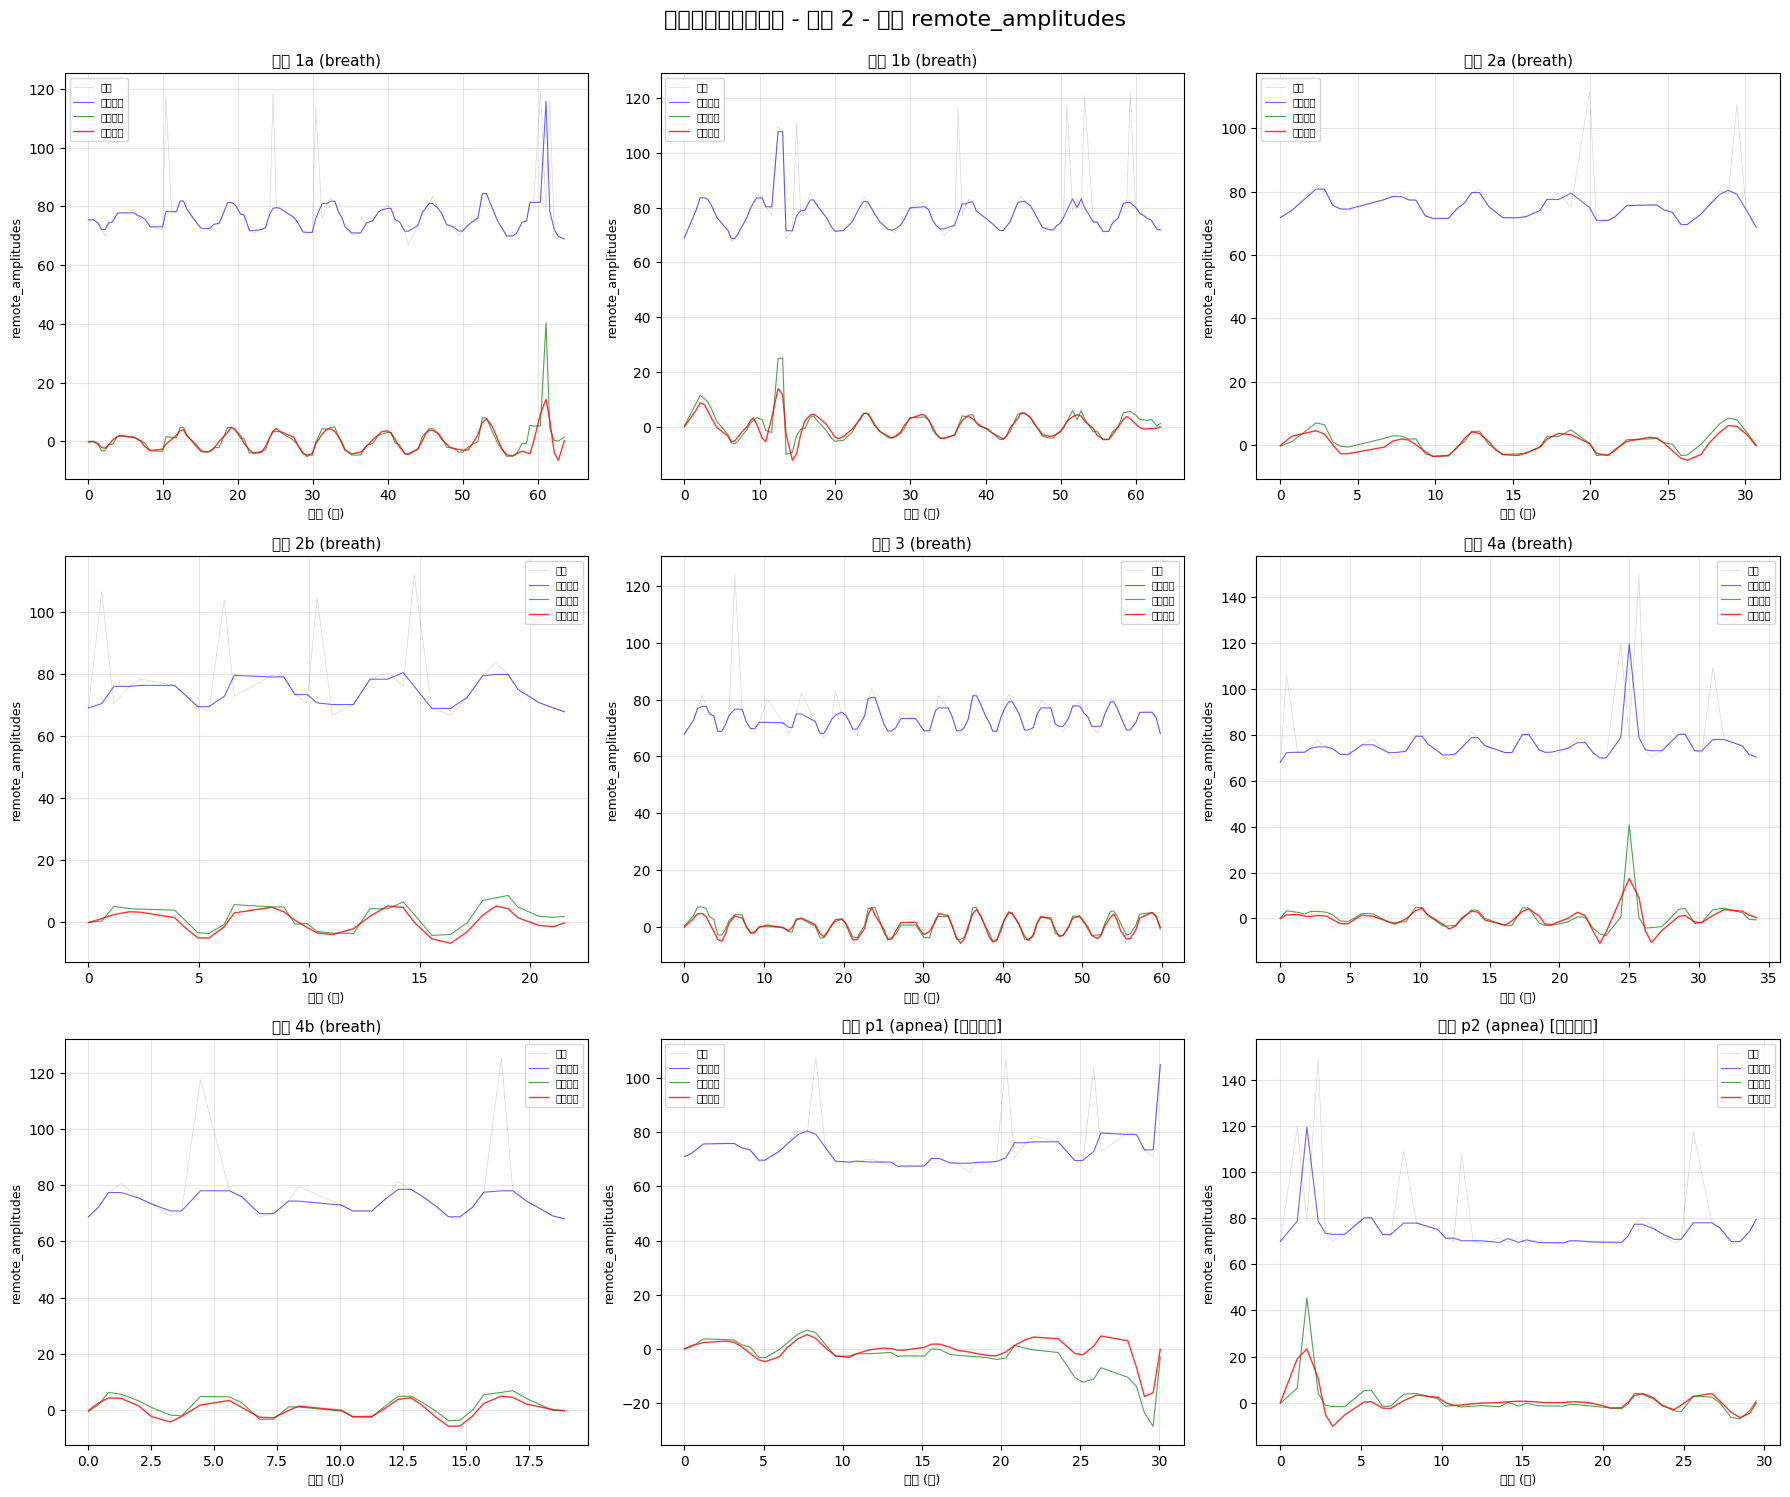

✓ 已生成3x3可视化图（展示变量: remote_amplitudes）


In [20]:
# ===== 分段结果可视化：3x3图展示 =====
visualization_variable = 'remote_amplitudes'
print("=== 分段结果可视化 ===")

# 检查必要的变量
if 'segment_processed' not in globals():
    print("⚠️  错误：请先运行Cell 40进行分段滤波处理")
elif 'visualization_variable' not in globals():
    print("⚠️  错误：请先运行Cell 37配置可视化变量")
    visualization_variable = 'amplitudes'  # 默认值
    print(f"  使用默认变量: {visualization_variable}")
else:
    # 创建3x3子图
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle(f'分段处理结果可视化 - 通道 {segment_channel} - 变量 {visualization_variable}', 
                 fontsize=16, y=0.995)
    
    # 段落顺序（a-i）
    seg_names = sorted(segment_processed.keys())
    
    for idx, seg_name in enumerate(seg_names):
        if segment_processed[seg_name] is None:
            # 空段落，显示空白
            ax = axes[idx // 3, idx % 3]
            ax.text(0.5, 0.5, f'段落 {seg_name}\n无数据', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'段落 {seg_name} (无数据)')
            continue
        
        seg_proc = segment_processed[seg_name]
        
        # 检查变量是否存在
        if visualization_variable not in seg_proc:
            ax = axes[idx // 3, idx % 3]
            ax.text(0.5, 0.5, f'段落 {seg_name}\n变量不存在', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'段落 {seg_name} (变量不存在)')
            continue
        
        ax = axes[idx // 3, idx % 3]
        
        # 获取数据
        var_data = seg_proc[visualization_variable]
        original = var_data['original']
        median_filtered = var_data['median_filtered']
        highpass_filtered = var_data['highpass_filtered']
        bandpass_filtered = var_data['bandpass_filtered']
        
        # 获取时间轴
        metadata = seg_proc.get('metadata', {})
        timestamps_ms = metadata.get('timestamps_ms', np.arange(len(original)))
        time_sec = (timestamps_ms - timestamps_ms[0]) / 1000.0 if len(timestamps_ms) > 0 else np.arange(len(original))
        
        # 绘制多条曲线
        ax.plot(time_sec, original, 'gray', linewidth=0.5, alpha=0.3, label='原始')
        ax.plot(time_sec, median_filtered, 'b-', linewidth=0.8, alpha=0.6, label='中值滤波')
        ax.plot(time_sec, highpass_filtered, 'g-', linewidth=0.8, alpha=0.7, label='高通滤波')
        ax.plot(time_sec, bandpass_filtered, 'r-', linewidth=1.0, alpha=0.8, label='带通滤波')
        
        # 添加段落类型标签
        seg_type = metadata.get('segment_type', 'breath')
        title = f'段落 {seg_name} ({seg_type})'
        if seg_type == 'apnea':
            title += ' [呼吸暂停]'
        ax.set_title(title, fontsize=11)
        ax.set_xlabel('时间 (秒)', fontsize=9)
        ax.set_ylabel(visualization_variable, fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=7, loc='best')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ 已生成3x3可视化图（展示变量: {visualization_variable}）")

In [21]:
# ===== 呼吸暂停检测 =====
# 参考 load_df_saved_frames(8).ipynb 的实现

print("=== 呼吸暂停检测 ===")

# 导入必要的函数
try:
    from scipy.ndimage import uniform_filter1d
except ImportError:
    print("⚠️  需要安装scipy: pip install scipy")
    uniform_filter1d = None

def apnea_est_with_context(x, fs, apnea_start, apnea_end, ctx_sec=10.0, win_sec=2.0, q=0.2):
    """
    在 GT apnea 段 [apnea_start, apnea_end] 周围取 context，
    用 context 学阈值，在 core 段内估计 low-energy 时长。
    
    参数:
    - x: 信号数组（median_filtered，未bandpass）
    - fs: 采样率
    - apnea_start: apnea段的起始样本索引
    - apnea_end: apnea段的结束样本索引
    - ctx_sec: context的时长（秒），默认10秒
    - win_sec: 滑动窗口时长（秒），默认2秒
    - q: 分位数，用于计算阈值，默认0.2
    
    返回:
    - apnea_est_sec: 估计的apnea时长（秒）
    - dbg: 调试信息字典
    """
    if uniform_filter1d is None:
        return np.nan, {"reason": "scipy not available"}
    
    x = np.asarray(x, float).reshape(-1)
    N = len(x)
    
    s = int(apnea_start)
    e = int(apnea_end)
    if e <= s or s < 0 or e > N:
        return np.nan, {"reason": "bad segment indices"}
    
    ctx = int(round(ctx_sec * fs))
    w0 = max(0, s - ctx)
    w1 = min(N, e + ctx)
    
    xw = x[w0:w1]
    if len(xw) < 5:
        return np.nan, {"reason": "window too short"}
    
    # baseline removal
    win = max(1, int(round(win_sec * fs)))
    baseline = uniform_filter1d(xw, size=win, mode="nearest")
    x0 = xw - baseline
    
    # RMS
    rms = np.sqrt(uniform_filter1d(x0*x0, size=win, mode="nearest"))
    
    # context mask（排除 core）
    core_s = s - w0
    core_e = e - w0
    mask_ctx = np.ones(len(rms), dtype=bool)
    mask_ctx[core_s:core_e] = False
    
    rms_ctx = rms[mask_ctx]
    if len(rms_ctx) == 0:
        return np.nan, {"reason": "no context points"}
    
    thresh = float(np.quantile(rms_ctx, q))
    low = rms < thresh
    
    # 只统计 core 段内
    low_core = low[core_s:core_e]
    apnea_est_sec = float(np.sum(low_core) / fs)
    
    dbg = {
        "w0": w0, "w1": w1,
        "core_s": s, "core_e": e,
        "thresh": thresh,
        "low_core_ratio": float(np.mean(low_core)) if len(low_core) else np.nan
    }
    return apnea_est_sec, dbg

# 检查必要的变量
if 'segment_processed' not in globals():
    print("⚠️  错误：请先运行Cell 40进行分段滤波处理")
else:
    # 对每个apnea段进行检测
    apnea_results = {}
    
    for seg_name in sorted(segment_processed.keys()):
        if segment_processed[seg_name] is None:
            continue
        
        seg_proc = segment_processed[seg_name]
        metadata = seg_proc.get('metadata', {})
        seg_type = metadata.get('segment_type', 'breath')
        
        if seg_type != 'apnea':
            continue
        
        print(f"\n处理段落 {seg_name} (apnea)...")
        
        # 获取median_filtered信号（用于apnea检测）
        # 优先使用amplitudes，如果没有则使用第一个可用变量
        var_for_apnea = None
        for var_name in ['amplitudes', 'remote_amplitudes', 'local_amplitudes']:
            if var_name in seg_proc:
                var_for_apnea = var_name
                break
        
        if var_for_apnea is None:
            print(f"  ⚠️  无法找到合适的变量进行apnea检测")
            continue
        
        median_filtered = seg_proc[var_for_apnea]['median_filtered']
        fs = metadata.get('sampling_rate', 2.0)
        
        # 获取原始段落的范围（在扩展后的数据中的位置）
        original_start = metadata.get('original_start', metadata.get('start_index', 0))
        original_end = metadata.get('original_end', metadata.get('end_index', len(median_filtered)))
        
        # 找到原始段落在当前数据中的实际位置
        indices = metadata.get('indices', np.arange(len(median_filtered)))
        if len(indices) > 0:
            # 找到original_start和original_end对应的索引位置
            start_mask = indices == original_start
            end_mask = indices == original_end
            
            if np.any(start_mask) and np.any(end_mask):
                apnea_start_idx = np.where(start_mask)[0][0]
                apnea_end_idx = np.where(end_mask)[0][0]
            else:
                # 如果找不到精确匹配，使用最接近的值
                apnea_start_idx = np.argmin(np.abs(indices - original_start))
                apnea_end_idx = np.argmin(np.abs(indices - original_end))
        else:
            # 如果没有indices，假设数据已经对齐
            apnea_start_idx = 0
            apnea_end_idx = len(median_filtered)
        
        # 执行apnea检测
        apnea_est_sec, dbg = apnea_est_with_context(
            median_filtered, fs, apnea_start_idx, apnea_end_idx,
            ctx_sec=10.0, win_sec=2.0, q=0.2
        )
        
        # 计算实际apnea时长（基于原始范围）
        apnea_actual_sec = (original_end - original_start + 1) / fs if fs > 0 else np.nan
        
        apnea_results[seg_name] = {
            'apnea_est_sec': apnea_est_sec,
            'apnea_actual_sec': apnea_actual_sec,
            'abs_err_sec': abs(apnea_est_sec - apnea_actual_sec) if not np.isnan(apnea_est_sec) else np.nan,
            'rel_err': (abs(apnea_est_sec - apnea_actual_sec) / apnea_actual_sec) 
                      if (not np.isnan(apnea_est_sec) and apnea_actual_sec > 0) else np.nan,
            'variable_used': var_for_apnea,
            'debug': dbg
        }
        
        if not np.isnan(apnea_est_sec):
            print(f"  ✓ 估计apnea时长: {apnea_est_sec:.2f} 秒")
            print(f"    实际apnea时长: {apnea_actual_sec:.2f} 秒")
            print(f"    绝对误差: {apnea_results[seg_name]['abs_err_sec']:.2f} 秒")
            if not np.isnan(apnea_results[seg_name]['rel_err']):
                print(f"    相对误差: {apnea_results[seg_name]['rel_err']*100:.1f}%")
        else:
            print(f"  ⚠️  无法估计apnea时长: {dbg.get('reason', 'unknown')}")
    
    # 保存结果到segment_processed
    for seg_name in apnea_results.keys():
        if seg_name in segment_processed and segment_processed[seg_name] is not None:
            if 'apnea_analysis' not in segment_processed[seg_name]:
                segment_processed[seg_name]['apnea_analysis'] = {}
            segment_processed[seg_name]['apnea_analysis'] = apnea_results[seg_name]
    
    print(f"\n✓ 完成apnea检测，共处理 {len(apnea_results)} 个apnea段")

=== 呼吸暂停检测 ===

处理段落 p1 (apnea)...
  ✓ 估计apnea时长: 6.45 秒
    实际apnea时长: 12.26 秒
    绝对误差: 5.81 秒
    相对误差: 47.4%

处理段落 p2 (apnea)...
  ✓ 估计apnea时长: 1.94 秒
    实际apnea时长: 12.26 秒
    绝对误差: 10.32 秒
    相对误差: 84.2%

✓ 完成apnea检测，共处理 2 个apnea段


=== 呼吸暂停检测结果可视化 ===


C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\3118415424.py:89: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\3118415424.py:89: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\3118415424.py:89: UserWarning: Glyph 31186 (\N{CJK UNIFIED IDEOGRAPH-79D2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\3118415424.py:89: UserWarning: Glyph 27573 (\N{CJK UNIFIED IDEOGRAPH-6BB5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\3118415424.py:89: UserWarning: Glyph 33853 (\N{CJK UNIFIED IDEOGRAPH-843D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cwdbo\AppData\Local\Temp\ipykernel_824\3118415424.py:89: UserWarning: Glyph 20272 (\N{CJK UNIFIE

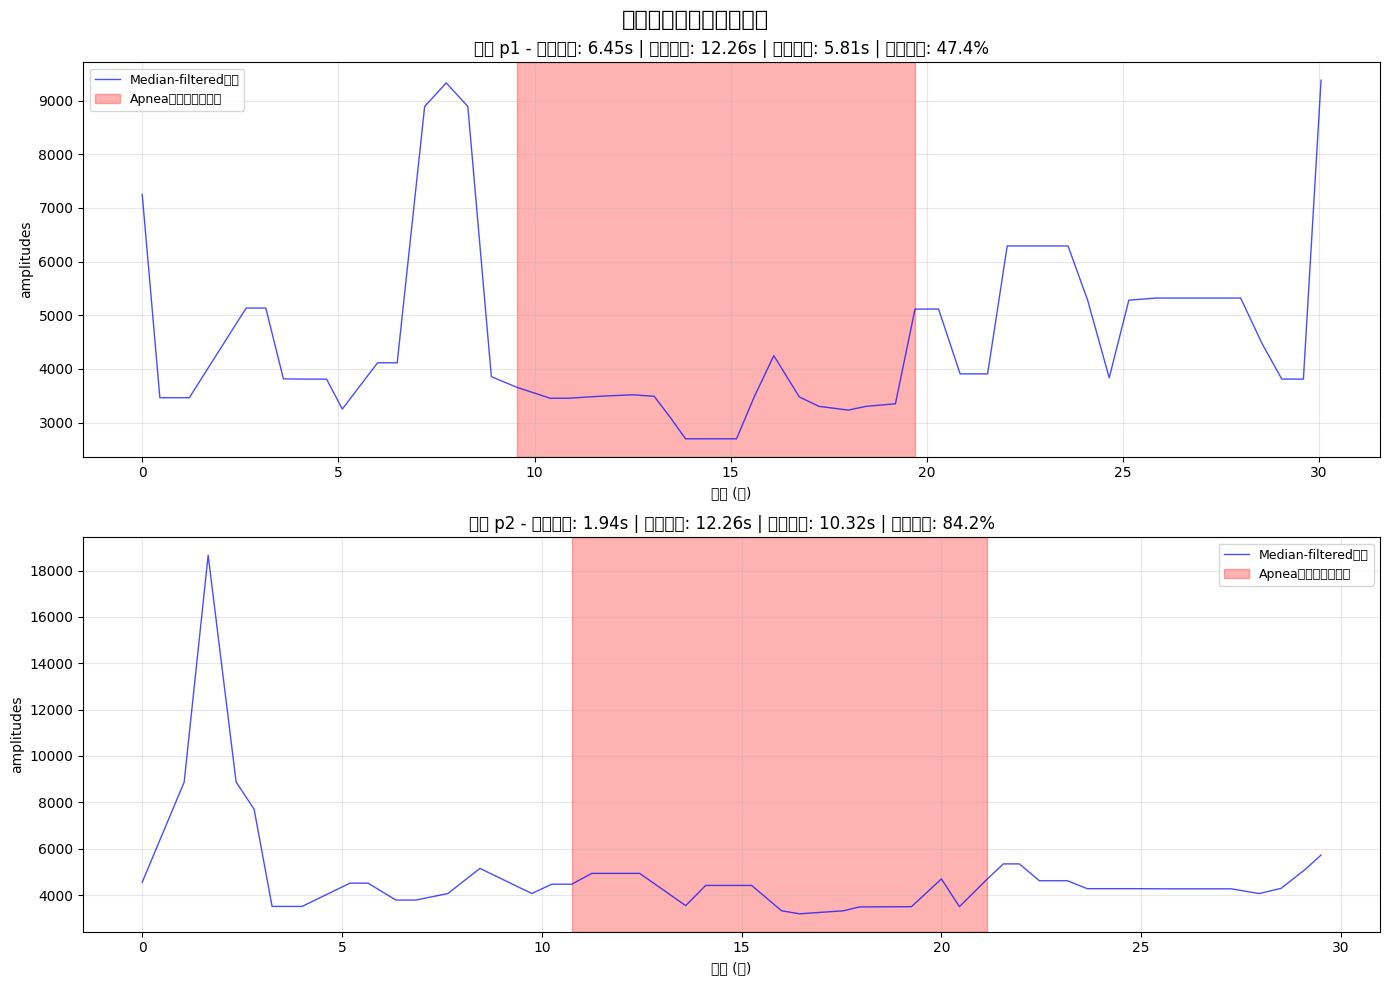

✓ 已生成apnea检测结果可视化（2 个apnea段）


In [22]:
# ===== 呼吸暂停检测结果可视化 =====

print("=== 呼吸暂停检测结果可视化 ===")

if 'segment_processed' not in globals():
    print("⚠️  错误：请先运行Cell 34进行呼吸暂停检测")
else:
    # 找出所有apnea段
    apnea_segments = []
    for seg_name in sorted(segment_processed.keys()):
        if segment_processed[seg_name] is None:
            continue
        metadata = segment_processed[seg_name].get('metadata', {})
        if metadata.get('segment_type') == 'apnea':
            apnea_segments.append(seg_name)
    
    if len(apnea_segments) == 0:
        print("⚠️  没有找到apnea段")
    else:
        n_apnea = len(apnea_segments)
        fig, axes = plt.subplots(n_apnea, 1, figsize=(14, 5*n_apnea))
        if n_apnea == 1:
            axes = [axes]
        
        fig.suptitle('呼吸暂停检测结果可视化', fontsize=16)
        
        for idx, seg_name in enumerate(apnea_segments):
            seg_proc = segment_processed[seg_name]
            apnea_analysis = seg_proc.get('apnea_analysis', {})
            
            if not apnea_analysis:
                axes[idx].text(0.5, 0.5, f'段落 {seg_name}\n无apnea检测结果', 
                              ha='center', va='center', transform=axes[idx].transAxes)
                axes[idx].set_title(f'段落 {seg_name} (无结果)')
                continue
            
            # 获取数据
            var_used = apnea_analysis.get('variable_used', 'amplitudes')
            if var_used not in seg_proc:
                axes[idx].text(0.5, 0.5, f'段落 {seg_name}\n变量不存在', 
                              ha='center', va='center', transform=axes[idx].transAxes)
                continue
            
            median_filtered = seg_proc[var_used]['median_filtered']
            metadata = seg_proc.get('metadata', {})
            timestamps_ms = metadata.get('timestamps_ms', np.arange(len(median_filtered)))
            time_sec = (timestamps_ms - timestamps_ms[0]) / 1000.0 if len(timestamps_ms) > 0 else np.arange(len(median_filtered))
            
            # 绘制信号
            axes[idx].plot(time_sec, median_filtered, 'b-', linewidth=1.0, alpha=0.7, label='Median-filtered信号')
            
            # 标记apnea段（原始范围）
            original_start = metadata.get('original_start', 0)
            original_end = metadata.get('original_end', len(median_filtered))
            indices = metadata.get('indices', np.arange(len(median_filtered)))
            
            if len(indices) > 0:
                start_mask = indices == original_start
                end_mask = indices == original_end
                if np.any(start_mask) and np.any(end_mask):
                    start_idx = np.where(start_mask)[0][0]
                    end_idx = np.where(end_mask)[0][0]
                    apnea_start_time = time_sec[start_idx] if start_idx < len(time_sec) else time_sec[0]
                    apnea_end_time = time_sec[end_idx] if end_idx < len(time_sec) else time_sec[-1]
                    
                    # 标记apnea区域
                    axes[idx].axvspan(apnea_start_time, apnea_end_time, alpha=0.3, color='red', 
                                     label='Apnea段（原始范围）')
            
            # 添加结果文本
            apnea_est = apnea_analysis.get('apnea_est_sec', np.nan)
            apnea_actual = apnea_analysis.get('apnea_actual_sec', np.nan)
            abs_err = apnea_analysis.get('abs_err_sec', np.nan)
            rel_err = apnea_analysis.get('rel_err', np.nan)
            
            info_text = f"估计时长: {apnea_est:.2f}s" if not np.isnan(apnea_est) else "估计时长: N/A"
            info_text += f" | 实际时长: {apnea_actual:.2f}s" if not np.isnan(apnea_actual) else " | 实际时长: N/A"
            if not np.isnan(abs_err):
                info_text += f" | 绝对误差: {abs_err:.2f}s"
            if not np.isnan(rel_err):
                info_text += f" | 相对误差: {rel_err*100:.1f}%"
            
            axes[idx].set_title(f'段落 {seg_name} - {info_text}', fontsize=12)
            axes[idx].set_xlabel('时间 (秒)', fontsize=10)
            axes[idx].set_ylabel(f'{var_used}', fontsize=10)
            axes[idx].grid(True, alpha=0.3)
            axes[idx].legend(fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        print(f"✓ 已生成apnea检测结果可视化（{n_apnea} 个apnea段）")

## ⚠️ 重要：段落配置格式更新

**段落配置格式已更新**，现在需要包含 `type` 字段：

```python
segment_config = {
    'a': {'start': 10, 'end': 50, 'type': 'breath'},   # 正常呼吸段
    'g': {'start': 301, 'end': 400, 'type': 'apnea'},   # 呼吸暂停段（前后会自动加10秒）
    ...
}
```

**对于apnea段：**
- 提取数据时会自动在前后各加10秒的context
- 会进行呼吸暂停检测
- 结果会保存到 `apnea_analysis` 字段中

In [23]:
# ===== 分段呼吸频率估计和IE比计算 =====

print("=== 分段呼吸频率估计和IE比计算 ===")

if 'segment_processed' not in globals():
    print("⚠️  错误：请先运行Cell 39进行滤波处理")
else:
    # 呼吸频率范围
    breath_freq_low = 0.1   # Hz
    breath_freq_high = 0.35  # Hz
    
    # 对每个段落进行分析
    for seg_name in sorted(segment_processed.keys()):
        if segment_processed[seg_name] is None:
            continue
        
        seg_proc = segment_processed[seg_name]
        metadata = seg_proc['metadata']
        sampling_rate = metadata['sampling_rate']
        
        print(f"\n分析段落 {seg_name}...")
        
        # 对每个变量进行呼吸频率估计
        for var_name in ['amplitudes', 'local_amplitudes', 'remote_amplitudes']:
            if var_name not in seg_proc:
                continue
            
            bandpass_data = seg_proc[var_name]['bandpass_filtered']
            
            if len(bandpass_data) < 10:  # 需要足够的数据点
                continue
            
            # 应用Hanning窗
            hanning_window = np.hanning(len(bandpass_data))
            windowed_data = bandpass_data * hanning_window
            
            # FFT分析
            fft_values = np.fft.rfft(windowed_data)
            fft_power = np.abs(fft_values) ** 2
            fft_freq = np.fft.rfftfreq(len(windowed_data), 1.0 / sampling_rate)
            
            # 找到呼吸频率范围内的最大功率对应的频率
            freq_mask = (fft_freq >= breath_freq_low) & (fft_freq <= breath_freq_high)
            if np.any(freq_mask):
                max_power_idx = np.argmax(fft_power[freq_mask])
                freq_indices = np.where(freq_mask)[0]
                max_freq_idx = freq_indices[max_power_idx]
                breathing_freq = fft_freq[max_freq_idx]
            else:
                breathing_freq = np.nan
            
            # 计算IE比（吸气时间/呼气时间）
            # 方法：基于带通滤波信号的零交叉点和峰值检测
            # 吸气相：从谷值（最小值）到峰值（最大值）
            # 呼气相：从峰值到下一个谷值
            ie_ratio = np.nan  # 默认值
            
            try:
                from scipy.signal import find_peaks
                
                # 找到峰值和谷值
                # 峰值对应吸气结束（信号上升的顶点）
                # 谷值对应呼气结束（信号下降的底点）
                min_distance = max(1, int(sampling_rate * 0.3))  # 至少间隔0.3秒
                
                peaks, peak_props = find_peaks(bandpass_data, distance=min_distance)
                valleys, valley_props = find_peaks(-bandpass_data, distance=min_distance)
                
                if len(peaks) >= 2 and len(valleys) >= 1:
                    dt = 1.0 / sampling_rate
                    
                    # 方法1：基于峰值和谷值的交替序列
                    # 构建一个完整的呼吸周期序列：谷值 -> 峰值 -> 谷值
                    all_points = []
                    for v in valleys:
                        all_points.append(('valley', v))
                    for p in peaks:
                        all_points.append(('peak', p))
                    all_points.sort(key=lambda x: x[1])
                    
                    # 计算每个呼吸周期的吸气时间和呼气时间
                    insp_times = []
                    exp_times = []
                    
                    for i in range(len(all_points) - 1):
                        curr_type, curr_idx = all_points[i]
                        next_type, next_idx = all_points[i + 1]
                        
                        time_interval = (next_idx - curr_idx) * dt
                        
                        if curr_type == 'valley' and next_type == 'peak':
                            # 从谷值到峰值 = 吸气相
                            insp_times.append(time_interval)
                        elif curr_type == 'peak' and next_type == 'valley':
                            # 从峰值到谷值 = 呼气相
                            exp_times.append(time_interval)
                    
                    # 计算平均IE比
                    if len(insp_times) > 0 and len(exp_times) > 0:
                        avg_insp_time = np.mean(insp_times)
                        avg_exp_time = np.mean(exp_times)
                        if avg_exp_time > 0:
                            ie_ratio = avg_insp_time / avg_exp_time
                
                # 如果方法1失败，尝试方法2：基于信号的一阶导数
                if np.isnan(ie_ratio) and len(bandpass_data) > 10:
                    # 计算一阶导数
                    diff_signal = np.diff(bandpass_data)
                    
                    # 找到上升段（正导数）和下降段（负导数）
                    # 上升段对应吸气，下降段对应呼气
                    rising_segments = []
                    falling_segments = []
                    
                    in_rising = False
                    in_falling = False
                    segment_start = 0
                    
                    for i in range(len(diff_signal)):
                        if diff_signal[i] > 0:  # 上升
                            if not in_rising:
                                segment_start = i
                                in_rising = True
                                in_falling = False
                        elif diff_signal[i] < 0:  # 下降
                            if in_rising:
                                # 结束上升段
                                rising_segments.append((segment_start, i))
                                in_rising = False
                            
                            if not in_falling:
                                segment_start = i
                                in_falling = True
                        else:  # 零或接近零
                            if in_rising:
                                rising_segments.append((segment_start, i))
                                in_rising = False
                            if in_falling:
                                falling_segments.append((segment_start, i))
                                in_falling = False
                    
                    # 计算平均吸气时间和呼气时间
                    if len(rising_segments) > 0 and len(falling_segments) > 0:
                        insp_times = [(end - start) * dt for start, end in rising_segments]
                        exp_times = [(end - start) * dt for start, end in falling_segments]
                        
                        if len(insp_times) > 0 and len(exp_times) > 0:
                            avg_insp = np.mean(insp_times)
                            avg_exp = np.mean(exp_times)
                            if avg_exp > 0:
                                ie_ratio = avg_insp / avg_exp
                                
            except Exception as e:
                # IE比计算失败，保持为NaN
                pass
            
            # 存储结果
            if 'breathing_analysis' not in seg_proc:
                seg_proc['breathing_analysis'] = {}
            
            seg_proc['breathing_analysis'][var_name] = {
                'breathing_freq': breathing_freq,  # Hz
                'breathing_rate': breathing_freq * 60 if not np.isnan(breathing_freq) else np.nan,  # bpm
                'ie_ratio': ie_ratio,
                'fft_freq': fft_freq,
                'fft_power': fft_power
            }
        
        # 显示结果摘要
        if 'breathing_analysis' in seg_proc:
            print(f"  呼吸频率估计和IE比:")
            for var_name in seg_proc['breathing_analysis'].keys():
                analysis = seg_proc['breathing_analysis'][var_name]
                freq = analysis['breathing_freq']
                rate = analysis['breathing_rate']
                ie_ratio = analysis['ie_ratio']
                
                info_parts = []
                if not np.isnan(freq):
                    info_parts.append(f"{freq:.3f} Hz ({rate:.1f} bpm)")
                else:
                    info_parts.append("频率: 无法估计")
                
                if not np.isnan(ie_ratio):
                    info_parts.append(f"IE比: {ie_ratio:.2f}")
                else:
                    info_parts.append("IE比: 无法计算")
                
                print(f"    {var_name}: {', '.join(info_parts)}")
    
    print(f"\n✓ 所有段落分析完成")

=== 分段呼吸频率估计和IE比计算 ===

分析段落 1a...
  呼吸频率估计和IE比:
    amplitudes: 0.250 Hz (15.0 bpm), IE比: 1.02
    local_amplitudes: 0.250 Hz (15.0 bpm), IE比: 1.00
    remote_amplitudes: 0.157 Hz (9.4 bpm), IE比: 0.97

分析段落 1b...
  呼吸频率估计和IE比:
    amplitudes: 0.230 Hz (13.8 bpm), IE比: 0.86
    local_amplitudes: 0.230 Hz (13.8 bpm), IE比: 1.04
    remote_amplitudes: 0.138 Hz (8.3 bpm), IE比: 0.94

分析段落 2a...
  呼吸频率估计和IE比:
    amplitudes: 0.236 Hz (14.1 bpm), IE比: 0.90
    local_amplitudes: 0.236 Hz (14.1 bpm), IE比: 0.82
    remote_amplitudes: 0.202 Hz (12.1 bpm), IE比: 0.90

分析段落 2b...
  呼吸频率估计和IE比:
    amplitudes: 0.194 Hz (11.6 bpm), IE比: 1.25
    local_amplitudes: 0.291 Hz (17.4 bpm), IE比: 0.93
    remote_amplitudes: 0.194 Hz (11.6 bpm), IE比: 0.67

分析段落 3...
  呼吸频率估计和IE比:
    amplitudes: 0.145 Hz (8.7 bpm), IE比: 0.85
    local_amplitudes: 0.145 Hz (8.7 bpm), IE比: 0.77
    remote_amplitudes: 0.226 Hz (13.6 bpm), IE比: 1.09

分析段落 4a...
  呼吸频率估计和IE比:
    amplitudes: 0.172 Hz (10.3 bpm), IE比: 1.04
    local

In [24]:
# ===== 保存分段处理结果到.npy文件 =====

print("=== 保存分段处理结果 ===")

if 'segment_processed' not in globals():
    print("⚠️  错误：请先运行Cell 39-40进行分段处理")
else:
    # 准备保存的数据结构
    # 格式：{段落名: {变量名: {处理步骤: 数据}, 'metadata': {...}, 'breathing_analysis': {...}}}
    
    # 保存完整的分段处理结果
    output_filename = "segment_processed_data.npy"
    
    # 创建一个更紧凑的保存格式
    save_data = {}
    
    for seg_name in sorted(segment_processed.keys()):
        if segment_processed[seg_name] is None:
            continue
        
        seg_proc = segment_processed[seg_name]
        save_data[seg_name] = {}
        
        # 保存每个变量的处理结果
        for var_name in ['amplitudes', 'phases', 'local_amplitudes', 'remote_amplitudes']:
            if var_name in seg_proc:
                save_data[seg_name][var_name] = {
                    'original': seg_proc[var_name]['original'],
                    'median_filtered': seg_proc[var_name]['median_filtered'],
                    'highpass_filtered': seg_proc[var_name]['highpass_filtered'],
                    'bandpass_filtered': seg_proc[var_name]['bandpass_filtered']
                }
        
        # 保存元数据
        if 'metadata' in seg_proc:
            save_data[seg_name]['metadata'] = seg_proc['metadata']
        
        # 保存呼吸分析结果
        if 'breathing_analysis' in seg_proc:
            save_data[seg_name]['breathing_analysis'] = seg_proc['breathing_analysis']
        
        # 保存呼吸暂停分析结果
        if 'apnea_analysis' in seg_proc:
            save_data[seg_name]['apnea_analysis'] = seg_proc['apnea_analysis']
    
    # 保存到.npy文件
    np.save(output_filename, save_data)
    
    print(f"✓ 已保存到文件: {output_filename}")
    print(f"  包含 {len(save_data)} 个段落的数据")
    
    # 显示文件大小
    import os
    if os.path.exists(output_filename):
        file_size_mb = os.path.getsize(output_filename) / (1024 * 1024)
        print(f"  文件大小: {file_size_mb:.2f} MB")
    
    # 显示数据结构摘要
    print(f"\n数据结构摘要:")
    for seg_name in sorted(save_data.keys()):
        seg_data = save_data[seg_name]
        n_vars = len([k for k in seg_data.keys() if k not in ['metadata', 'breathing_analysis']])
        print(f"  段落 {seg_name}: {n_vars} 个变量, "
              f"数据点数: {seg_data.get('metadata', {}).get('n_points', 'N/A')}")
    
    print(f"\n💡 提示：可以使用以下代码加载数据：")
    print(f"   loaded_data = np.load('{output_filename}', allow_pickle=True).item()")

=== 保存分段处理结果 ===
✓ 已保存到文件: segment_processed_data.npy
  包含 9 个段落的数据
  文件大小: 0.10 MB

数据结构摘要:
  段落 1a: 4 个变量, 数据点数: 99
  段落 1b: 4 个变量, 数据点数: 101
  段落 2a: 4 个变量, 数据点数: 46
  段落 2b: 4 个变量, 数据点数: 32
  段落 3: 4 个变量, 数据点数: 96
  段落 4a: 4 个变量, 数据点数: 54
  段落 4b: 4 个变量, 数据点数: 32
  段落 p1: 5 个变量, 数据点数: 47
  段落 p2: 5 个变量, 数据点数: 46

💡 提示：可以使用以下代码加载数据：
   loaded_data = np.load('segment_processed_data.npy', allow_pickle=True).item()


In [25]:
x_cont = np.asarray(x_obj["detrended_order1"], dtype=float).reshape(-1)

import pickle
with open("breathing_analysis_results_cs.pkl", "wb") as f:
    pickle.dump(breathing_analysis_results, f)
